In [1]:
#This Cell Defines the parameters
import time
import cPickle as pickle
#import cv2
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy.integrate import RK45
from scipy.integrate import quad
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.linear_model import LinearRegression

#Parameters
eta = 1.0					#Dispersion Parameter
n = 36						#Number of x-components
x_0 = np.zeros(n)			#Initial x
#x_0[0] = 0.99 
v_0 = x_0 					#v = x * (Integrating Factor). In this case IF = exp(eta*t), so IF(0) = 1 
sigma = 0.5					#SD of noise
S = np.zeros((n,n))			#covariance matrix for the noise
for i in xrange(5):
	S[i][i] = sigma 
h = 0.005					#Time step
h_range = np.arange(0.005, 0.025, 0.005)
t_final = 20.				#Terminal simulation time
nsteps = int(t_final / h)	#Number of steps
l = 0.8						#mixing parameter for the stratification algorithm
#Setup of Stratification
strata = [[-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75], [-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75]] 		#Boundary points of the strata in x_0 (or also later coordinates)
nu_0_weights = 1. / (len(strata) + 1.) * np.ones(len(strata) + 1)
n_exits = 20
n_iterations = 50
bin_edges = np.arange(-1., 1., 0.025)
bin_edges_later_vars = np.arange(-.3, .3, 0.0075)  #'later vars' refers to x_1,...,x_n. only x_0 has a direct source of noise, so the range it explores is different
bin_diff = 0.025
bin_diff_later_vars = 0.0075

J = (len(strata[0]) + 1)**2
#Initialize the collection of injection measures and weights
#The initial nu is a single point in each region, with weight 1
nu_0_points = []
nu_0_probs = []
K = len(strata[0]) + 1
for i in xrange(K-1):
    for j in xrange(K-1): 
        y = np.zeros(n)
        y[0] = strata[0][i] - 0.1
        y[4] = strata[1][j] - 0.1
        nu_0_points.append([y])
        nu_0_probs.append([1.])
    y = np.zeros(n)
    y[0] = strata[0][i] - 0.1
    y[4] = strata[1][K-2] + 0.1
    nu_0_points.append([y])
    nu_0_probs.append([1.])
for j in xrange(K-1): 
    y = np.zeros(n)
    y[0] = strata[0][K-2] + 0.1
    y[4] = strata[1][j] - 0.1
    nu_0_points.append([y])
    nu_0_probs.append([1.])
y = np.zeros(n)
y[0] = strata[0][K-2] + 0.1
y[4] = strata[1][K-2] + 0.1
nu_0_points.append([y])
nu_0_probs.append([1.])


In [2]:
#This Cell contains Definitions of the main functions
def f_IFRK(y, t):
    d = np.zeros(n)
    d[0] = (y[1] - y[n-2]) * y[n-1] + 4 * y[0] - 16 * (y[0]*y[0]*y[0]) #RK4 function for a double well in 2 coordinates
    d[1] = (y[2] - y[n-1]) * y[0] - y[1]
    d[n-1] = (y[0] - y[n-3]) * y[n-2] - y[n-1]
    for i in range(2, n-1):
        d[i] = (y[i+1] - y[i-2]) * y[i-1] - y[i]
    d[4] = (y[5] - y[2]) * y[3] + 4 * y[4] - 16 * (y[4]*y[4]*y[4])
    return d

def g_IFRK(y, t): 
	noise = np.zeros(n)
	for i in xrange(n):
		noise[i] = S[i][i] * np.exp(eta * t)
	return noise


#The function that moves a stochastic system dX = fdt + gdW ahead by time h via Runge-Kutta
def RK_SDE_Step(y, t, f, g, h): 
	m = len(y)
	dW = np.random.normal(0.0, np.sqrt(h), m)
	b = np.random.binomial(1, 0.5)	#The binary RV used in the improved Euler RK method for sde's
	if b == 0:
		b = -1
	K_1 = h * f(y, t) + (dW - np.sqrt(h) * b) * g(y, t) 
	K_2 = h * f(y + K_1, t + h) + (dW + np.sqrt(h)*b) * g(y + K_1, t + h)
	y_new = y + 0.5 * (K_1 + K_2) 
	return y_new

#The Function that evolves the deterministic part of an SDE only by time h using RK4
def RK_4_Step(y, t, f, h):
	K_1 = h * f(y, t)
	K_2 = h * f(y + 0.5 * K_1, t + 0.5 * h)
	K_3 = h * f(y + 0.5 * K_2, t + 0.5 * h)
	K_4 = h * f(y + K_3, t + h)
	y_new = y + (1.0 / 6.0) * (K_1 + 2. * K_2 + 2. * K_3 + K_4)
	return y_new

#The test function to be used in the stratified algorithm
def phi(x):
	return np.sum(x[0]**2)


#This function uses the ones above to generate the data (x, t) of the system evolving in time for a given step size
def RK_SDE_Sim(y_0, nsteps, f, g, h):
	x = np.zeros((nsteps,n))
	x[0] = x_0
	v = x_0
	for i in  xrange(nsteps-1): 
		v = x[i]
		v = RK_SDE_Step(v, 0., f, g, h)
		x[i + 1] = np.exp(-1.0 * eta * h) * v 
	t_range = np.arange(0.0, t_final, h)
	return x, t_range

#This function evolves x and t similarly, but by using RK4 on the deterministic part of v, converting back to x, then adding the appropriate noise
def RK_4_Sim(x_0, nsteps, f, S, h, phi, G):
	m = len(x_0)
	mu_estimate = 0.0
	x = np.zeros((nsteps,n))
	x[0] = x_0
	v = x_0
	for i in  xrange(nsteps-1): 
		v = x[i]
		j = idx(x[i], strata)
		v = RK_4_Step(v, 0., f_IFRK, h)
		noise = np.zeros(m)
		for k in xrange(m):
			noise[k] = S[k][k] * np.sqrt(h) * np.random.normal(0., 1.)
		x[i + 1] = v + noise
		l = idx(x[i+1], strata)
		if j != l:
			G[j][l] += 1
		mu_estimate += phi(x[i+1]) / nsteps
	t_range = np.arange(0.0, t_final, h)
	return x, t_range, mu_estimate, G


################################

#Index function returning the current stratum
#Index function returning the current stratum
def idx(y, strata):
    K = len(strata[0]) + 1
    for i in xrange(len(strata[0]) - 1):
        if (strata[0][i] <= y[0] < strata[0][i+1]):
            for k in xrange(len(strata[1]) - 1):
                if (strata[1][k] <= y[4] < strata[1][k+1]):
                    return (i + 1) * K + (k + 1)
            if y[4] >= strata[1][len(strata[1])-1]:
                return (i+1) * K + len(strata[1])
            if y[4] <= strata[1][0]:
                return (i+1)*K
        
    if y[0] < strata[0][0]:
        for k in xrange(len(strata[1]) - 1):
            if (strata[1][k] <= y[4] < strata[1][k+1]):
                return k+1
        if y[4] >= strata[1][len(strata[1])-1]:
            return len(strata[1])
        if y[4] <= strata[1][0]:
            return 0
            
    if y[0] >= strata[0][len(strata[0])-1]:
        for k in xrange(len(strata[1]) - 1):
            if (strata[1][k] <= y[4] < strata[1][k+1]):
                return (K-1) * K + (k + 1)
        if y[4] >= strata[1][len(strata[1])-1]:
            return (K-1) * K + len(strata[1])
        if y[4] <= strata[1][0]:
            return (K-1) * K

###########
#Note: For now, the algorithm will just pick from nu_j with equal probability for all points, and will average the trajectories for each iteration for the final answer

#Draw a sample from the current j-th injection measure
def injection_draw(points, probs):
	num_choices = len(points)
	probs_sum = np.sum(np.array(probs))
	probs_normalized = probs
	for i in xrange(len(probs)):
		probs[i] = probs[i] / probs_sum
	index_chosen = np.random.choice(num_choices, p=probs_normalized)
	return points[index_chosen]

#def RK_4_Sim_Exit(strata, nu_points, nu_weights, f, S, h, j):
    

#Run from a starting measure until exiting, return the exit point and the trajectory the particle took
def RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h):
	J = (len(strata[0]) + 1)**2
	exit_points = []
	trajectory = []
	for j in xrange(J):
		trajectory.append([])
	exit_times = np.zeros(J)
	test_fcn_avg = np.zeros(n_polys)
	for j in xrange(J):
		test_fcn_avg_current = np.zeros(n_polys)
		prob_sum = np.sum(nu_probs[j])
		if prob_sum <= 1.e-8 :
			nu_points[j] = nu_0_points[j]
			nu_probs[j] = np.ones(len(nu_0_points[j]))
		start_point = injection_draw(nu_points[j], nu_probs[j])
		idx_0 = idx(start_point, strata)
		current_idx = idx_0
		x_current = start_point
		while (current_idx == idx_0):
			trajectory[j].append(x_current)
			test_fcn_avg_current += test_function_values(coef_1, coef_2, coef_3, x_current)
			#compute the next step
			v = x_current
			v = RK_4_Step(v, 0., f_IFRK, h)
			noise = np.zeros(len(v))
			for k in xrange(len(v)):
				noise[k] = S[k][k] * np.sqrt(h) * np.random.normal(0., 1.)
			x_current = v + noise
			#Update the index so the next loop checks if an exit has occurred
			current_idx = idx(x_current, strata)
			exit_times[j] += 1
		test_fcn_avg_current = test_fcn_avg_current * (1. / exit_times[j])
		test_fcn_avg += test_fcn_avg_current * nu_weights[j]
		exit_points.append(x_current)
    
	return exit_points, trajectory, exit_times, test_fcn_avg


#Note: For now at least, the iteration will just run for n_exits excursions in each stratum, so that the number of exit points is controlled. This can be changed later
def RK_4_stratified_iteration(n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h):
	nu_points_next = []
	nu_probs_next = []
	time_spent = np.zeros(J)
	for j in xrange(J):
		nu_points_next.append([])
		nu_probs_next.append([])
	nu_weights_next = np.zeros(J)
	test_fcn_avg = np.zeros(n_polys)
	G = np.zeros((J,J))
	for i in xrange(n_exits):
		exit_points, trajectory, exit_times, test_fcn_avg_current = RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h)
		for j in xrange(J):
			exit_idx = idx(exit_points[j], strata)
			nu_points_next[exit_idx].append(exit_points[j])
			nu_probs_next[exit_idx].append(nu_weights[j])
			G[j][exit_idx] += 1.
			time_spent += exit_times
		test_fcn_avg += (1. / n_exits) * test_fcn_avg_current
	#If nu_points_next is empty for some j, replace it with a single point
	for j in xrange(J):
		if len(nu_points_next[j]) == 0:
			nu_points_next[j].append(nu_0_points[j][0])
			nu_probs_next[j].append(1.)
	#Normalize G and compute the weights
	for i in xrange(J):
		row_sum = np.sum(G[i])
		for j in xrange(J):
			G[i][j] = G[i][j] / row_sum
			nu_weights_next[j] += G[i][j] * nu_weights[i]
    
	#Compile the histograms over each excursion
	return nu_points_next, nu_probs_next, nu_weights_next, test_fcn_avg, time_spent

#New function - eigenvector version
def RK_4_stratified_iteration_eig(n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h):
	nu_points_next = []
	nu_probs_next = []
	xi_points = []
	occupation = []    #The list of points in each excursion, for forming the occupation measure
	for j in xrange(J):
		nu_points_next.append([])
		nu_probs_next.append([])
		xi_points.append([])
	time_spent = np.zeros(J)
	nu_weights_next = np.zeros(J)
	test_fcn_avg = np.zeros(n_polys)
	G = np.zeros((J,J))
	for i in xrange(n_exits):
		exit_points, trajectory, exit_times, test_fcn_avg_current = RK_4_Sim_Exit(strata, nu_points, nu_probs, nu_weights, f, S, h)
		for j in xrange(J):
			exit_idx = idx(exit_points[j], strata)
			xi_points[j].append([exit_points[j], exit_idx])
			G[j][exit_idx] += 1.
			time_spent += exit_times
		occupation.append(trajectory)
	#If nu_points_next is empty for some j, replace it with a single point
	#Normalize G and compute the weights
	for i in xrange(J):
		row_sum = np.sum(G[i])
		for j in xrange(J):
			G[i][j] = G[i][j] / row_sum
			nu_weights_next[j] += G[i][j] * nu_weights[i]
    
    #Compute the weights for the eigenvector version
#	evals, evecs = np.linalg.eig(G.T)
#	evec1 = evecs[:,np.isclose(evals, 1)]
#	evec1 = evec1[:,0]
#	nu_weights_next = evec1 / evec1.sum()
    
    #Option - Just use a high power of G instead of the eig function
	for k in xrange(100*J):
		nu_weights_next = np.dot(nu_weights, G)
	nu_weights_next = nu_weights_next / np.sum(nu_weights_next)
    
    #Form the histogram of the occupation measure with the newly calculated weights
	for k in xrange(n_exits):
		for j in xrange(J):
			exit_time = len(occupation[k][j])
			for i in xrange(exit_time):
				x_point = occupation[k][j][i]
				test_fcn_avg += (1. / n_exits) * (1. / exit_time) * nu_weights_next[j] * test_function_values(coef_1, coef_2, coef_3, x_point)

    #Build the new injection measures from xi and nu_weights_next
	for j in xrange(J):
		for i in xrange(n_exits):
			exit_point = xi_points[j][i][0]
			exit_idx = xi_points[j][i][1]
			nu_points_next[exit_idx].append(exit_point)
			nu_probs_next[exit_idx].append(nu_weights_next[j])
            
	for j in xrange(J):
		if len(nu_points_next[j]) == 0:
			nu_points_next[j].append(nu_0_points[j][0])
			nu_probs_next[j].append(1.)
            
    
	#Compile the histograms over each excursion
	return nu_points_next, nu_probs_next, nu_weights_next, test_fcn_avg, time_spent

def RK_4_Stratified(n_iterations, n_exits, strata, nu_points, nu_probs, nu_weights, f, S, h, l):
	nu_points_next, nu_probs_next, nu_weights_next, iteration_hist = RK_4_stratified_iteration(n_exits, strata, nu_points, nu_probs, nu_weights, f_IFRK, S, h)
	H = iteration_hist[0]
	for i in xrange(n_iterations-1):
		nu_points_next, nu_probs_next, nu_weights_next, iteration_hist = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f, S, h)
		#H = (1. - l) * H + l * iteration_hist[0]
		H += iteration_hist[0]		#Option: Simply average the histogram of all iterations with equal weight, not using lambda (l)
	#Finally, Normalize H so it is a density
	H_sum = 1. * np.sum(H)
	for i in xrange(len(H)):
		H[i] = H[i] / H_sum
	stratified_hist = (H, bin_edges)
	return nu_points_next, nu_probs_next, nu_weights_next, stratified_hist

def TV_dist(hist_1, hist_2, bin_diff):
    l = len(hist_1)
    d = 0.
    for i in xrange(l):
        d += abs(hist_1[i]-hist_2[i]) * bin_diff
    d = d / 2.
    return d

#Function that stores the average of two injection measures
def nu_mix(nu_points_1, nu_probs_1, nu_points_2, nu_probs_2, alpha):
    if len(nu_points_2) == 0:
        return nu_points_1, nu_probs_1
    else: 
        nu_points_mixed = []
        nu_probs_mixed = []
        l1 = len(nu_points_1)
        l2 = len(nu_points_2)
        for i in xrange(l1):
            nu_points_mixed.append(nu_points_1[i])
            p = (1. - alpha) * nu_probs_1[i]
            nu_probs_mixed.append(p)
        for i in xrange(l2):
            nu_points_mixed.append(nu_points_2[i])
            p = (alpha) * nu_probs_2[i]
            nu_probs_mixed.append(p)
        p_sum = 0.
        for i in xrange(l1):
            p_sum += nu_probs_mixed[i]
        for i in xrange(l2):
            p_sum += nu_probs_mixed[l1 + i]
        for i in xrange(l1+l2):
            nu_probs_mixed[i] = nu_probs_mixed[i] / p_sum
        return nu_points_mixed, nu_probs_mixed
        
        

#Function that mixes a sequence of m injection measures
def nu_mix_sequence(nu_points_sequence, nu_probs_sequence, alpha):
    nu_points_mixed = nu_points_sequence[0]
    nu_probs_mixed = nu_probs_sequence[0]
    l = len(nu_points_sequence)
    for i in xrange(l-1):
        nu_points_mixed, nu_probs_mixed = nu_mix(nu_points_mixed, nu_probs_mixed, nu_points_sequence[i+1], nu_probs_sequence[i+1], alpha)
    return nu_points_mixed, nu_probs_mixed

#Function that mixes a sequence of injection measures for each j
#Note that in this function, the dimensions of the tot sequence are l, then J. So nu_points_sequence_tot[1] is J sets of points at time 1
def nu_mix_sequence_tot(nu_points_sequence_tot, nu_probs_sequence_tot, alpha):
    l = len(nu_points_sequence_tot)
    nu_points_mixed_tot = []
    nu_probs_mixed_tot = []
    for j in xrange(J):
        nu_points_sequence = []
        nu_probs_sequence = []
        for i in xrange(l):
            nu_points_sequence.append(nu_points_sequence_tot[i][j])
            nu_probs_sequence.append(nu_probs_sequence_tot[i][j])
        nu_points_mixed, nu_probs_mixed = nu_mix_sequence(nu_points_sequence, nu_probs_sequence, alpha)
        
        nu_points_mixed_tot.append(nu_points_mixed)
        nu_probs_mixed_tot.append(nu_probs_mixed)
    
    return nu_points_mixed_tot, nu_probs_mixed_tot

def hist_mean(hist, bin_edges, bin_diff):
    n_bins = len(bin_edges) - 1
    m = 0.
    for i in xrange(n_bins):
        midpoint = 0.5 * (bin_edges[i] + bin_edges[i + 1])
        m += hist[i] * midpoint * bin_diff
    return m


In [4]:
#Testing out the injection measure mixing functions
alpha = 0.5
nu_points_sequence_tot = []
nu_probs_sequence_tot = []
J=3
for i in xrange(3):
    points_1 = [10. + i, 20. + i]
    points_2 = [30. + i, 40. + i]
    probs_1=[0.75, 0.25]
    probs_2=[0.5, 0.5]
    points_3 = [50. + i, 60. + i, 70. + i]
    probs_3 = [0.3, 0.3, 0.4]
    nu_points_tot = [points_1, points_2, points_3]
    nu_probs_tot = [probs_1, probs_2, probs_3]
    nu_points_sequence_tot.append(nu_points_tot)
    nu_probs_sequence_tot.append(nu_probs_tot)

#points_mixed, probs_mixed = nu_mix(points_1, probs_1, points_2, probs_2, alpha)
#print points_mixed
#print probs_mixed

points_mixed, probs_mixed = nu_mix_sequence_tot(nu_points_sequence_tot, nu_probs_sequence_tot, alpha)
print points_mixed
print probs_mixed

[[10.0, 20.0, 11.0, 21.0, 12.0, 22.0], [30.0, 40.0, 31.0, 41.0, 32.0, 42.0], [50.0, 60.0, 70.0, 51.0, 61.0, 71.0, 52.0, 62.0, 72.0]]
[[0.1875, 0.0625, 0.1875, 0.0625, 0.375, 0.125], [0.125, 0.125, 0.125, 0.125, 0.25, 0.25], [0.075, 0.075, 0.1, 0.075, 0.075, 0.1, 0.15, 0.15, 0.2]]


In [5]:
#This cell will generate random polynomial test functions to be used later. 
#Current Plan: Generate and record them here, and use the same test functions for every run later. 
#Curretly, the test functions do not have cross terms in the coordinates, for computational purposes
n = 36
n_polys = 3
max_degree = 3

#coef_1 = np.zeros((n_polys,n))
#coef_2 = np.zeros((n_polys,n))
#coef_3 = np.zeros((n_polys,n))
#
#generate the coefficients for all 10 polynomials
#for i in xrange(n_polys):
#    #Create an array for the coefficients of the order 1 terms
#    for j in xrange(n):
#        coef_1[i][j] = np.random.uniform(0.,1.)
#        coef_2[i][j] = np.random.uniform(0.,1.)
#        coef_3[i][j] = np.random.uniform(0.,1.)
#
#Note: The first 3 test functions will use only coef_1, so they are linear. The next 3 use coef_1 and coef_2, so they are quadratic. 
#Then 6 cubic test functions
#for i in xrange(3):
#    for j in xrange(n):
#        coef_2[i][j] = 0.
#        coef_3[i][j] = 0.
#for i in xrange(3):
#    for j in xrange(n):
#        coef_3[i+3][j] = 0. 

#with open("L96_test_functions_max_degree_3.dat", "wb") as f:
#    pickle.dump([coef_1, coef_2, coef_3], f)

In [3]:
with open("L96_test_functions_max_degree_3.dat", "rb") as f:
    coef = pickle.load(f)
coef_1 = coef[0]
coef_2 = coef[1]
coef_3 = coef[2]
print coef_1[0]

#Function that takes the coefficient arrays and a n-dim point and returns the polynomial value
def poly_n(poly_coef_1, poly_coef_2, poly_coef_3, x):
    poly_sum = 0.
    for j in xrange(n):
        poly_sum += poly_coef_1[j] * x[j]
        poly_sum += poly_coef_2[j] * x[j] * x[j]
        poly_sum += poly_coef_3[j] * x[j] * x[j] * x[j]
    return poly_sum

def test_function_values(coef_1, coef_2, coef_3, x):
    values = np.zeros(3)
    for i in xrange(3):
        values[i] = poly_n(coef_1[3 *i], coef_2[3 * i], coef_3[3 *i], x)
    return values

[0.69606537 0.78760013 0.61247228 0.06431147 0.48002876 0.73071774
 0.67772761 0.5441237  0.68662686 0.15694714 0.8081202  0.10902309
 0.64854003 0.56495641 0.14456955 0.95523132 0.6827482  0.05362998
 0.4131169  0.90634416 0.7727519  0.96634066 0.76459991 0.06073537
 0.67109902 0.62921137 0.66866493 0.6371225  0.52701425 0.85378645
 0.05010802 0.49152286 0.04884116 0.13307387 0.49488826 0.69632816]


In [195]:
#This cell contains the code (commented by default) for testing and plots

#Test Plot, unstratified
#x, t_range, mu_estimate_unstratified = RK_4_Sim(x_0, nsteps, f_IFRK, S, h, phi)
#un_stratified_hist = np.histogram(x[:,0], bins=bin_edges, density=True)
#H = un_stratified_hist[0]
#H_sum = np.sum(H)
#for i in xrange(len(H)):
#	H[i] = H[i] / H_sum
#un_stratified_hist = (H, bin_edges)
#plt.plot(un_stratified_hist[1][1:], un_stratified_hist[0])
#plt.show()

#Test for a single excursion starting in each stratum
#exit_points, trajectory, exit_times, trajectory_hist = RK_4_Sim_Exit(strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#for j in xrange(J):
#	plt.plot(np.array(trajectory[j])[:,0], xrange(len(trajectory[j])), 'o')
#plt.show()
#plt.plot(trajectory_hist[2][1:], trajectory_hist[0][1], 'o')
#plt.show()


#Iteration_Test
#Optional - Compute some iterations then plot the last one
#Optional - Use the eig version
#n_exits = 20
#n_iterations = 100
#strata = [-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75] 		#Boundary points of the strata in x_0
#J = len(strata) + 1
#h = 0.025
#nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration_eig(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#for i in xrange(n_iterations):
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration_eig(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#    plt.plot(xrange(8), nu_weights_next, 'bo')
#    plt.show()
    
#    raw_input("Press Enter to continue...")

#stratified_mixed_hist = []
#nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
#hist = iteration_hist[0][0]

#for i in xrange(n_exits):
#    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
#    hist = hist + iteration_hist[0][0]
#    H = hist / (i + 2.)
    #hist = hist / (np.sum(hist) * bin_diff)
#    
#    plt.plot(bin_edges[1:], hist,'o')
#    plt.show()
#    raw_input("Press Enter to continue...")

#for j in xrange(J):
#	plt.hist(np.array(nu_points_next[j])[:,0], bins=bin_edges, weights=np.array(nu_probs_next[j]))
#plt.plot(xrange(J), nu_weights_next)
#plt.plot(iteration_hist[1][1:], iteration_hist[0][0], 'o')
#plt.show()
#iteration_hist[0][3]

#Iteration test - eig version

#Stratified Algorithm Test
#for s in xrange(4):
#	nu_points_next, nu_probs_next, nu_weights_next, stratified_hist = RK_4_Stratified(n_iterations * (s+1), n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h, l)
#	plt.plot(stratified_hist[1][1:], stratified_hist[0])
#plt.show()

#Test for the polynomial generator and test function evaluator
#x = np.ones(n)
#a = test_function_values(coef_1, coef_2, coef_3, x)
#print a

In [196]:
#This Cell will compute and store the main data from a run of the un-stratified algorithm
#h = 0.005
#t_final = 200000
#nsteps = int(t_final / h)
#r = nsteps / 1000
#K = 8
#J = K**2
#strata = [[-1. + (2.* (j+1.) / K) for j in xrange(K-1)], [-1. + (2.* (j+1.) / K) for j in xrange(K-1)]]
#un_stratified_data = []
#un_stratified_data.append([coef_1, coef_2, coef_3])
#print 'Starting'
#for i in xrange(20):
#    print '***'
#    print 200 * i + 0
#    G = np.zeros((J,J))
#    x, t_range, mu_estimate_unstratified, G = RK_4_Sim(x_0, r, f_IFRK, S, h, phi, G)
#    test_fcn_avg = np.zeros(n_polys)
#    for j in xrange(r):
#        test_fcn_avg += (1. / r) * test_function_values(coef_1, coef_2, coef_3, x[j])
#    un_stratified_data.append([test_fcn_avg, G])
    
#    for k in xrange(199):
#        print (200 * i) + k + 1
#        x, t_range, mu_estimate_unstratified, G = RK_4_Sim(x[r-1], r, f_IFRK, S, h, phi, G)
#        test_fcn_avg = np.zeros(n_polys)
#        for j in xrange(r):
#            test_fcn_avg += (1. / r) * test_function_values(coef_1, coef_2, coef_3, x[j])
#        un_stratified_data.append([test_fcn_avg, G])
                
#with open("un_strat_2D_test_functions.dat", "wb") as f:
#    pickle.dump(un_stratified_data, f)

#Note: The G for this run is being computed with 8 strata, as in the first cell

In [94]:
#This Cell will compute and store the main data from a run of the stratified algorithm, for both versions
#Stratified run with averaging of injection measures
stratified_data_eig_comparison = []
n_exits = 300
n_iterations = 200
n_mixing = 10
h = 0.005
stratified_data = []
K=6
J = K**2
strata = [[-1. + (2.* (j+1.) / K) for j in xrange(K-1)], [-1. + (2.* (j+1.) / K) for j in xrange(K-1)]]
nu_0_points = []
nu_0_probs = []
for i in xrange(K-1):
    for j in xrange(K-1): 
        y = np.zeros(n)
        y[0] = strata[0][i] - (1. / J)
        y[4] = strata[1][j] - (1. / J)
        nu_0_points.append([y])
        nu_0_probs.append([1.])
    y = np.zeros(n)
    y[0] = strata[0][i] - (1. / J)
    y[4] = strata[1][K-2] + (1. / J)
    nu_0_points.append([y])
    nu_0_probs.append([1.])
for j in xrange(K-1): 
    y = np.zeros(n)
    y[0] = strata[0][K-2] + (1. / J)
    y[4] = strata[1][j] - (1. / J)
    nu_0_points.append([y])
    nu_0_probs.append([1.])
y = np.zeros(n)
y[0] = strata[0][K-2] + (1. / J)
y[4] = strata[1][K-2] + (1. / J)
nu_0_points.append([y])
nu_0_probs.append([1.])
nu_0_weights = (1. / J) * np.ones(J)
data_current_J = []


nu_points_sequence = [nu_0_points]
nu_probs_sequence = [nu_0_probs]
nu_points_sequence_eig = [nu_0_points]
nu_probs_sequence_eig = [nu_0_probs]


nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
data_current_J.append([nu_points_next, nu_probs_next, nu_weights_next, time_spent])

nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig = RK_4_stratified_iteration_eig(n_exits, strata, nu_0_points, nu_0_probs, nu_0_weights, f_IFRK, S, h)
data_current_J.append([nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, time_spent_eig])

nu_points_sequence.append(nu_points_next)
nu_probs_sequence.append(nu_probs_next)
nu_points_sequence_eig.append(nu_points_next_eig)
nu_probs_sequence_eig.append(nu_probs_next_eig)
    
for i in xrange(n_mixing - 1):
    print i + 1
    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, nu_points_next, nu_probs_next, nu_weights_next, f_IFRK, S, h)
    data_current_J.append([nu_points_next, nu_probs_next, nu_weights_next, time_spent])
            
    nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig = RK_4_stratified_iteration_eig(n_exits, strata, nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, f_IFRK, S, h)
    data_current_J.append([nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, time_spent_eig])
    
    nu_points_sequence.append(nu_points_next)
    nu_probs_sequence.append(nu_probs_next)
    nu_points_sequence_eig.append(nu_points_next_eig)
    nu_probs_sequence_eig.append(nu_probs_next_eig)

for i in xrange(n_iterations - n_mixing):
    print i + 10
    points_mixed, probs_mixed = nu_mix_sequence_tot(nu_points_sequence, nu_probs_sequence, alpha)
    points_mixed_eig, probs_mixed_eig = nu_mix_sequence_tot(nu_points_sequence_eig, nu_probs_sequence_eig, alpha)
    
    nu_points_next, nu_probs_next, nu_weights_next, iteration_hist, time_spent = RK_4_stratified_iteration(n_exits, strata, points_mixed, probs_mixed, nu_weights_next, f_IFRK, S, h)
    data_current_J.append([nu_points_next, nu_probs_next, nu_weights_next, time_spent])
            
    nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, iteration_hist_eig, time_spent_eig = RK_4_stratified_iteration_eig(n_exits, strata, points_mixed_eig, probs_mixed_eig, nu_weights_next_eig, f_IFRK, S, h)
    data_current_J.append([nu_points_next_eig, nu_probs_next_eig, nu_weights_next_eig, time_spent_eig])
    
    nu_points_sequence = [nu_points_sequence[i+1] for i in xrange(n_mixing - 1)]
    nu_probs_sequence = [nu_probs_sequence[i+1] for i in xrange(n_mixing - 1)]
    nu_points_sequence_eig = [nu_points_sequence_eig[i+1] for i in xrange(n_mixing - 1)]
    nu_probs_sequence_eig = [nu_probs_sequence_eig[i+1] for i in xrange(n_mixing - 1)]
    
    nu_points_sequence.append(nu_points_next)
    nu_probs_sequence.append(nu_probs_next)
    nu_points_sequence_eig.append(nu_points_next_eig)
    nu_probs_sequence_eig.append(nu_probs_next_eig)
    
    
stratified_data.append(data_current_J)
#with open("l96_4_noise_double_well_2D_strata", "wb") as f:
#    pickle.dump(stratified_data, f)

In [46]:
#a = [1., 2., 3., 4.]
#a = [a[i+1] for i in xrange(3)]
#print a

In [4]:
#Load the un-stratified algorithm data
with open("un_strat_2D_test_functions_06_1_multiple_runs.dat", "rb") as f:
    un_stratified_data = pickle.load(f)
n_runs = 15
n_hists_per_run = 50
n_hists_tot = 15 * 50
n_steps_per_hist = 20000
#h=0.005. Each run started at the origin

In [273]:
#Create random endpoints for the strata, with the bottom of the wells inside one. 

#Endpoints in the first dimension for one of the strata centered on a well
#a1 = np.random.uniform(0.1, 0.4)
#a2 = np.random.uniform(0.1, 0.4)

#b1 = np.random.uniform(0.05, 0.45) 
#b2 = np.random.uniform(0.05, 0.45)

#strata0 = [-0.5 - a1, -0.5 + a2, 0.5 - b1, 0.5 + b2]

#c1 = np.random.uniform(0.05, 0.45)
#c2 = np.random.uniform(0.05, 0.45)

#d1 = np.random.uniform(0.05, 0.45) 
#d2 = np.random.uniform(0.05, 0.45)

#strata1 = [-0.5 - c1, -0.5 + c2, 0.5 - d1, 0.5 + d2]

#strata=[strata0, strata1]

#with open("l96_random_2D_strata_K_6.dat", "wb") as f:
#    pickle.dump(strata, f)

In [ ]:
#Create an average test function value just from the potentials, assuming independence of coordinates





In [68]:
#Re-order the computations here to see how the number of runs affects the fluctuations. Average the points for time i at each run 
#from the same start point, and make a sequence of those. Also, get more than 2 runs starting from each well. 

J=36
#This cell is for testing the data from the un-stratified algorithm
n_hist = 50
n_runs = 15
n_hist_tot = 50*15 
G_sum = np.zeros((n_hist_tot,36,36))
G_avg = np.zeros((n_hist_tot,36,36))

test_fcn_nu_sum_un_strat = np.zeros((n_runs, n_hists_per_run, 3))
test_fcn_nu_avg_un_strat = np.zeros((n_runs, n_hists_per_run, 3))

test_fcn_nu_sum_un_strat_one_stratum = np.zeros((n_runs, n_hists_per_run, J, 3))
test_fcn_nu_avg_un_strat_one_stratum = np.zeros((n_runs, n_hists_per_run, J, 3))

for k in xrange(n_runs):
    nu_points = un_stratified_data[1][1]
    for j in xrange(J):
        











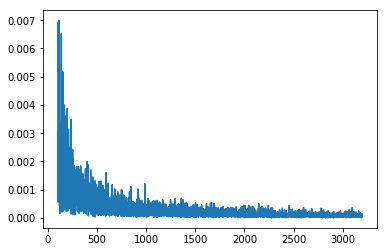

In [239]:
plt.plot(np.arange(100, n_hist_tot-1,1), [np.sum(abs(test_fcn_nu_avg_un_strat[i+1] - test_fcn_nu_avg_un_strat[i])) for i in np.arange(100, n_hist_tot-1,1)])

In [250]:
time_init = 2500
polynum = 0
print np.log(np.sqrt(np.var([test_fcn_nu_avg_un_strat[i][polynum] for i in np.arange(time_init, 3199, 1)])))
print np.sqrt(np.var([test_fcn_nu_avg_un_strat[i][polynum] for i in np.arange(time_init, 3199, 1)]))
print test_fcn_nu_avg_un_strat[3199][polynum]

-7.607873519930941
0.0004965265905451506
0.0009530273317196763


In [18]:
print test_fcn_nu_avg_un_strat[n_hist_tot-1][0]
for i in xrange(36):
    G_avg[n_hist_tot-1][i] = G_avg[n_hist_tot-1][i] / np.sum(G_avg[n_hist_tot-1][i])
weights_true = np.dot(np.ones(36),np.linalg.matrix_power(G_avg[n_hist_tot-1],2000))
weights_true = weights_true / (np.sum(weights_true))
print weights_true
print n_points_un_strat

0.0009530273317196763
[0.00146813 0.01723209 0.00714001 0.00706589 0.0170031  0.0014289
 0.01630945 0.08329431 0.04984354 0.04908966 0.08214749 0.01624681
 0.00625997 0.04620871 0.02279874 0.02251485 0.04557539 0.0061227
 0.00612253 0.04620288 0.0228423  0.02267849 0.04586436 0.00613012
 0.01647641 0.0838524  0.04999829 0.04962261 0.0836399  0.01652891
 0.00147558 0.01745357 0.00713715 0.00714017 0.01758983 0.00149476]
169012197


In [128]:
for i in xrange(3200):
    print len(un_stratified_data[i+2][1][16])

97
164
85
46
127
122
175
251
176
86
117
149
133
176
127
100
98
89
114
120
164
136
110
76
141
206
78
96
172
115
207
121
169
208
65
52
81
120
206
210
108
122
97
243
88
114
93
140
39
56
55
148
197
31
98
138
299
104
243
122
166
183
113
211
209
151
50
225
135
170
182
173
131
111
48
173
108
170
112
97
74
146
172
112
184
160
289
184
174
163
171
92
51
215
141
168
86
75
188
113
39
200
133
209
122
65
172
111
145
99
141
119
163
104
136
198
156
87
177
105
214
183
216
182
104
138
193
164
43
121
83
160
203
124
158
156
128
110
114
196
139
116
144
152
110
81
60
73
42
220
257
136
38
95
19
85
61
136
15
142
140
92
162
151
97
88
81
115
116
137
265
155
100
85
153
98
42
238
130
117
146
235
158
120
104
88
108
94
227
73
189
177
98
39
131
189
84
175
126
131
105
121
166
216
140
147
204
87
140
83
127
80
78
157
117
157
114
45
105
164
72
148
111
69
156
124
183
95
96
282
172
239
113
199
104
174
31
117
120
133
152
87
123
37
77
291
219
186
100
56
69
187
202
100
43
109
116
65
224
160
45
233
217
46
136
126
78
143
173
2

121
132
66
59
56
150
192
213
99
155
144
169
181
161
90
141
130
80
207
177
155
172
43
35
198
152
195
241
114
105
123
206
94
138
137
79
118
147
92
102
108
165
235
101
80
163
134
169
184
136
253
157
122
67
127
141
68
179
131
87
152
139
191
177
49
101
248
120
166
152
178
119
138
148
140
145
186
152
225
89
180
93
200
145
109
80
196
76
76
156
85
147
190
39
177
140
138
222
235
77
131
129
250
204
232
53
117
43
125
117
171
54
164
204
192
186
99
144
108
103
133
108
185
142
160
152
205
104
204
46
34
195
181
183
97
227
158
171
43
133
114
125
204
169
197
257
29
156
55
119
57
36
70
126
147
53
213
119
180
121
81
103
158
238
201
192
107
253
93
159
122
131
159
126
193
186
156
122
95
126
135
141
104
193
141
194
215
110
204
138
117
105
151
124
133
170
123
170
175
100
159
199
192
71
51
187
93
77
63
116
69
57
246
186
175
133
110
127
81
86
52
63
136
107
255
78
139
194
109
148
99
119
41
98
89
138
148
94
217
117
102
125
199
57
177
60
142
102
201
112
126
69
137
138
161
133
148
150
169
131
144
161
139
142
194
1

IndexError: list index out of range

In [130]:
#Seeing the number of nu points in each stratum for the un-strat algorithm
n_points_un_strat_one_stratum = np.zeros(J)
for j in xrange(J):
    for i in xrange(n_hist_tot-1):
        n_points_un_strat_one_stratum[j] += len(un_stratified_data[i+2][1][j])

In [5]:
with open("l96_random_2D_strata_K_6.dat", "rb") as f:
    strata = pickle.load(f)

In [36]:
print strata
print len(stratified_data[0][0])

[[-0.8284165263188158, -0.28921967852243785, 0.33179286969660515, 0.7377178691774229], [-0.6784599821490527, -0.2103531466139752, 0.3183500838614702, 0.6263407362890464]]
25


In [6]:
#f.close()
with open("L96_2D_Strata_Test_Functions_05_27_only_eig.dat", "rb") as f:
    stratified_data_2D_J_comparison = pickle.load(f)
n_iterations = 1000
n_exits = 600
J=25
#random strata
h=0.005

In [53]:
stratified_data = stratified_data_2D_J_comparison[0]

def norm_density_un_normalized(x):
    return np.exp(-0.5 * x * x)
    
def double_well_density_un_normalized(x):
    return np.exp(2. * (x * x) - 4. * (x * x * x * x))
    
Z_normal = quad(norm_density_un_normalized, -np.inf, np.inf)[0]
Z_double_well = quad(double_well_density_un_normalized, -np.inf, np.inf)[0]

def norm_density(x):
    val = norm_density_un_normalized(x) / Z_normal
    return val
    
def double_well_density(x):
    val = double_well_density_un_normalized(x) / Z_double_well
    return val

In [54]:
#Testing that the integrations give sinsible results
#poly_num = 6
#print quad(norm_density, -np.inf, np.inf)[0]
#phi_with_density = lambda x : (coef_1[poly_num][0] * x + coef_2[poly_num][0] * (x * x) + coef_3[poly_num][0] * (x * x * x)) * double_well_density(x)
#phi_with_density = lambda x : (coef_1[poly_num][15] * x + coef_2[poly_num][15] * (x * x) + coef_3[poly_num][15] * (x * x * x)) * norm_density(x)
#print quad(phi_with_density, -np.inf, np.inf)

#Calculate the second moment for both densities
#The first and third moments are 0 by symmenty

x2_with_norm = lambda x : (x**2) * norm_density(x)
moment_2_norm = quad(x2_with_norm, -np.inf, np.inf)
#print moment_2_norm

x2_with_double_well = lambda x : (x**2) * double_well_density(x)
moment_2_double_well = quad(x2_with_double_well, -np.inf, np.inf)
print moment_2_double_well




(0.26044932412179905, 2.205760867285067e-09)


In [57]:
#Calculate the average of each test function over the invariant measure, assuming exp(-V) form. 
#Use that the polynomials have a form that allows each term's expectation to be calculated
n=36
degree = 1
phi_avg_inv = np.zeros(n_polys)

for poly_num in xrange(3):
    #handle the 0, 4 corrdinates, which have double wells, first
    phi_with_density = lambda x : (coef_1[3 * poly_num][0] * x + coef_2[3 * poly_num][0] * (x * x) + coef_3[3 * poly_num][0] * (x * x * x)) * double_well_density(x)
    phi_avg_inv[poly_num] += quad(phi_with_density, -np.inf, np.inf)[0]
    
    phi_with_density = lambda x : (coef_1[3 * poly_num][4] * x + coef_2[3 * poly_num][4] * (x * x) + coef_3[3 * poly_num][4] * (x * x * x)) * double_well_density(x)
    phi_avg_inv[poly_num] += quad(phi_with_density, -np.inf, np.inf)[0]
    
    for l in np.arange(1, 4, 1):
        phi_with_density = lambda x : (coef_1[3 * poly_num][l] * x + coef_2[3 * poly_num][l] * (x * x) + coef_3[3 * poly_num][l] * (x * x * x)) * norm_density(x)
        phi_avg_inv[poly_num] += quad(phi_with_density, -np.inf, np.inf)[0]
    
    for l in np.arange(5, n, 1):
        phi_with_density = lambda x : (coef_1[3 * poly_num][l] * x + coef_2[3 * poly_num][l] * (x * x) + coef_3[3 * poly_num][l] * (x * x * x)) * norm_density(x)
        phi_avg_inv[poly_num] += quad(phi_with_density, -np.inf, np.inf)[0]
print phi_avg_inv

#Problem: How do we know what the variance is for each coordinate, given that we only have (direct) noise in some of them. 
#The question is whether or not there is a simple form of the invariant measure
    




#Function that draws points from the invariant measure
#def inv_draw(n_draws):

#raw_input("Press Enter to continue...")

[ 0.         19.98348988 18.14073292]


In [48]:
#Compute the running averages of the histograms
bin_edges_phi = np.arange(-3.5, 3.52, 0.02)
bin_diff_phi = 0.02
n_bins_phi = len(bin_edges_phi) - 1
H_phi_stratified_sum = np.zeros((n_polys, n_bins_phi))
H_phi_stratified_avg = np.zeros((n_iterations, n_polys, n_bins_phi))
#print n_bins_phi

#Start computing the running average with the histograms from the first iteration
H_phi = stratified_data[0][2]
#Normalize H_phi
for s in xrange(n_polys):
    H_phi[s] = H_phi[s] / (np.sum(H_phi[s]) * bin_diff_phi)
H_phi_stratified_sum += H_phi
H_phi_stratified_avg[0] = H_phi_stratified_sum


for i in xrange(n_iterations-1):
    H_phi = stratified_data[i+1][2]
    #Normalize H_phi
    for s in xrange(n_polys):
        H_phi[s] = H_phi[s] / (np.sum(H_phi[s]) * bin_diff_phi)
    H_phi_stratified_sum += H_phi
    H_phi_stratified_avg[i+1] = H_phi_stratified_sum / (i + 2.)

plt.plot(bin_edges_phi[1:], H_phi_stratified_avg[n_iterations-1][2], 'o')
plt.show()



##Calculate the average of each test function based on its histogram
#def phi_avg_from_hist(H, bin_edges):
    

In [9]:
#Comparing the convergence of nu_tot for the basic and eig versions
stratified_data = stratified_data_2D_J_comparison[0]

weights_sum = (1. / 36.) * np.ones((n_iterations, 36))   #weights_sum[k] will be the sum of the first k weight vectors
weights_sum_eig = (1. / 36.) * np.ones((n_iterations,36))
for k in xrange(n_iterations - 1):
    weights_sum[k+1] = weights_sum[k] + np.array(stratified_data[2*k][2])
    weights_sum_eig[k+1] = weights_sum_eig[k] + np.array(stratified_data[2*k+1][2])
#    w=weights/(k+1.)
#    plt.plot(xrange(10), w, 'bo')
#    plt.show()
    
#    raw_input("Press Enter to continue...")

m = 5
for k in xrange(5):
    r = 200 * k + 150
    #plt.plot(xrange(64), weights_sum[r] / (r + 1.), label = 'iter ' + str(r))
    plt.plot(xrange(36), weights_sum_eig[r] / (r + 1.), label = 'iter ' + str(r))
    plt.ylim(0.,0.1)
    plt.xlabel('j')
    plt.ylabel('weight')
plt.plot(xrange(36), weights_true, 'o', label='True Weights')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#for k in xrange(50):
#Try: Series of basis functions
#Try: TV distance of histograms
#Try: Indicator functions on strata

#For different J, Try: Plot log(TV-distance), using histograms, as a line with negative slope, with time as the x-axis, and plot the lines for several J on the same graph

plt.show()

IndexError: list index out of range

In [127]:
weights_avg_eig = weights_sum[999] / 1000.
weights_rel_error = [abs(weights_avg_eig[j]-weights_true[j])/weights_true[j] for j in xrange(J)]
plt.plot(xrange(J), weights_rel_error)

In [41]:
#Plotting tghe evolution of injection measures for stratified vs un-stratified
#For the un-stratified run, the injection measure is the empirical measure of all steps that transition between strata. Other steps are not counted, similar to estimating G in the un-stratified run. 
K=6
J=36
stratified_data = stratified_data_2D_J_comparison[0]

#Compute the test function averages for the stratified run
test_sum_nu_eig = np.zeros((n_iterations, J, 3))
test_avg_nu_eig = np.zeros((n_iterations, J, 3))
test_nu_eig_un_avg = np.zeros((n_iterations, J, 3))
test_sum_nu_eig_tot = np.zeros((n_iterations, 3))
test_avg_nu_eig_tot = np.zeros((n_iterations, 3))

nu_points_eig = stratified_data[1][0]
nu_probs_eig = stratified_data[1][1]
nu_weights_eig = stratified_data[1][2]
test_fcn_sum_current = np.zeros((J, 3))
test_fcn_sum_current_tot = np.zeros(3)
for j in xrange(J):
    n_points = len(nu_points_eig[j])
    for l in xrange(n_points):
        test_nu_eig_un_avg[0][j] += nu_probs_eig[j][l] * test_function_values(coef_1, coef_2, coef_3, nu_points_eig[j][l])
    test_fcn_sum_current[j] += test_nu_eig_un_avg[0][j]
test_sum_nu_eig[0] = test_fcn_sum_current
test_avg_nu_eig[0] = test_sum_nu_eig[0]
for j in xrange(J):
    test_fcn_sum_current_tot += nu_weights_eig[j] * test_fcn_sum_current[j]
test_sum_nu_eig_tot[0] = test_fcn_sum_current_tot
test_avg_nu_eig_tot[0] = test_sum_nu_eig_tot[0]

for i in xrange(n_iterations - 1):
    print i+1
    nu_points_eig = stratified_data[2*i+1][0]
    nu_probs_eig = stratified_data[2*i+1][1]
    nu_weights_eig = stratified_data[2*i+1][2]
    test_fcn_sum_current = np.zeros((J,3))
    test_fcn_sum_current_tot = np.zeros(3)
    for j in xrange(J):
        n_points = len(nu_points_eig[j])
        for l in xrange(n_points):
            test_nu_eig_un_avg[i][j] += nu_probs_eig[j][l] * test_function_values(coef_1, coef_2, coef_3, nu_points_eig[j][l])
        test_fcn_sum_current[j] += test_nu_eig_un_avg[i][j]
    for j in xrange(J):
        test_fcn_sum_current_tot += nu_weights_eig[j] * test_fcn_sum_current[j]
    test_sum_nu_eig[i+1] = test_sum_nu_eig[i] + test_fcn_sum_current
    test_avg_nu_eig[i+1] = test_sum_nu_eig[i+1] / (i + 2.)
    test_sum_nu_eig_tot[i+1] = test_sum_nu_eig_tot[i] + test_fcn_sum_current_tot
    test_avg_nu_eig_tot[i+1] = test_sum_nu_eig_tot[i+1] / (i+2.) 
    

plt.plot(np.log(xrange(n_iterations - 1)), [np.log(np.sum(abs(test_avg_nu_eig_tot[i+1] - test_avg_nu_eig_tot[i]))) for i in xrange(n_iterations - 1)])
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [226]:
#plt.plot(np.log(xrange(n_iterations)), [np.sum(np.log(abs(nu_weights_eig_avg[i] - weights_true))) for i in xrange(n_iterations)])
plt.plot(np.log(xrange(n_iterations)), [np.log(np.sum(abs((nu_weights_eig_avg[i] - weights_true)/weights_true))) for i in xrange(n_iterations)])

In [7]:
#Creating Histograms for the test functions in the stratified and un-stratified runs
stratified_data = stratified_data_2D_J_comparison[0]
J=36
n_iterations=1000

bin_edges_phi = np.arange(-3.5, 3.5, 0.02)
bin_diff_phi = 0.02

stratified_phi_hists = []
bin_edges_phi = np.arange(-3.5, 3.5, 0.02)
bin_diff_phi = 0.02
for s in xrange(3):
    poly_num = s
    H = np.zeros((n_iterations, len(bin_edges_phi)-1))
    for i in xrange(n_iterations):
        print s, i
        nu_weights_eig = stratified_data[i][2]
        for j in xrange(J):
            nu_points_eig = stratified_data[i][0][j]
            nu_probs_eig = stratified_data[i][1][j]
            n_points = len(nu_points_eig)
            for l in xrange(n_points):
                test_value = test_function_values(coef_1, coef_2, coef_3, nu_points_eig[l])[poly_num]
                test_weight = nu_weights_eig[j] * nu_probs_eig[l]
                H[i] = H[i] + np.histogram([test_value], bins=bin_edges_phi, weights=[test_weight])[0]
        H[i] = H[i] / (np.sum(H[i]) * bin_diff_phi)
    stratified_phi_hists.append(H)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


1 402
1 403
1 404
1 405
1 406
1 407
1 408
1 409
1 410
1 411
1 412
1 413
1 414
1 415
1 416
1 417
1 418
1 419
1 420
1 421
1 422
1 423
1 424
1 425
1 426
1 427
1 428
1 429
1 430
1 431
1 432
1 433
1 434
1 435
1 436
1 437
1 438
1 439
1 440
1 441
1 442
1 443
1 444
1 445
1 446
1 447
1 448
1 449
1 450
1 451
1 452
1 453
1 454
1 455
1 456
1 457
1 458
1 459
1 460
1 461
1 462
1 463
1 464
1 465
1 466
1 467
1 468
1 469
1 470
1 471
1 472
1 473
1 474
1 475
1 476
1 477
1 478
1 479
1 480
1 481
1 482
1 483
1 484
1 485
1 486
1 487
1 488
1 489
1 490
1 491
1 492
1 493
1 494
1 495
1 496
1 497
1 498
1 499
1 500
1 501
1 502
1 503
1 504
1 505
1 506
1 507
1 508
1 509
1 510
1 511
1 512
1 513
1 514
1 515
1 516
1 517
1 518
1 519
1 520
1 521
1 522
1 523
1 524
1 525
1 526
1 527
1 528
1 529
1 530
1 531
1 532
1 533
1 534
1 535
1 536
1 537
1 538
1 539
1 540
1 541
1 542
1 543
1 544
1 545
1 546
1 547
1 548
1 549
1 550
1 551
1 552
1 553
1 554
1 555
1 556
1 557
1 558
1 559
1 560
1 561
1 562
1 563
1 564
1 565
1 566
1 567
1 56

2 785
2 786
2 787
2 788
2 789
2 790
2 791
2 792
2 793
2 794
2 795
2 796
2 797
2 798
2 799
2 800
2 801
2 802
2 803
2 804
2 805
2 806
2 807
2 808
2 809
2 810
2 811
2 812
2 813
2 814
2 815
2 816
2 817
2 818
2 819
2 820
2 821
2 822
2 823
2 824
2 825
2 826
2 827
2 828
2 829
2 830
2 831
2 832
2 833
2 834
2 835
2 836
2 837
2 838
2 839
2 840
2 841
2 842
2 843
2 844
2 845
2 846
2 847
2 848
2 849
2 850
2 851
2 852
2 853
2 854
2 855
2 856
2 857
2 858
2 859
2 860
2 861
2 862
2 863
2 864
2 865
2 866
2 867
2 868
2 869
2 870
2 871
2 872
2 873
2 874
2 875
2 876
2 877
2 878
2 879
2 880
2 881
2 882
2 883
2 884
2 885
2 886
2 887
2 888
2 889
2 890
2 891
2 892
2 893
2 894
2 895
2 896
2 897
2 898
2 899
2 900
2 901
2 902
2 903
2 904
2 905
2 906
2 907
2 908
2 909
2 910
2 911
2 912
2 913
2 914
2 915
2 916
2 917
2 918
2 919
2 920
2 921
2 922
2 923
2 924
2 925
2 926
2 927
2 928
2 929
2 930
2 931
2 932
2 933
2 934
2 935
2 936
2 937
2 938
2 939
2 940
2 941
2 942
2 943
2 944
2 945
2 946
2 947
2 948
2 949
2 950
2 95

In [22]:
print len(stratified_data_2D_J_comparison[0])

1000


In [8]:
n_hists_per_run = 50
n_runs = 15
n_burn_in = 5

un_strat_phi_hists = []
for k in xrange(n_runs):
    un_strat_phi_hists.append([])
bin_edges_phi = np.arange(-3.5, 3.5, 0.02)
bin_diff_phi = 0.02 
for k in xrange(n_runs):
    hists_current = []
    for s in xrange(3):
        H = np.histogram([], bins=bin_edges_phi)[0]
        poly_num = s
        for i in xrange(n_hists_per_run-n_burn_in):
            print k, s, i+n_burn_in
            nu_points_tot = un_stratified_data[k * n_hists_per_run + i + n_burn_in + 1][1]
            n_points_tot = 0
            for j in xrange(J):
                n_points_tot = n_points_tot + len(nu_points_tot[j])
            for j in xrange(J):
                nu_points = nu_points_tot[j]
                n_points = len(nu_points)
                for l in xrange(n_points):
                    test_value = test_function_values(coef_1, coef_2, coef_3, nu_points[l])[poly_num]
                    test_weight = 1. / n_points_tot
                    H = H + np.histogram([test_value], bins=bin_edges_phi, weights=[test_weight])[0]
        H = H / (np.sum(H) * bin_diff_phi)
        hists_current.append(H)
    un_strat_phi_hists.append(hists_current)

0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 0 30
0 0 31
0 0 32
0 0 33
0 0 34
0 0 35
0 0 36
0 0 37
0 0 38
0 0 39
0 0 40
0 0 41
0 0 42
0 0 43
0 0 44
0 0 45
0 0 46
0 0 47
0 0 48
0 0 49
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 1 15
0 1 16
0 1 17
0 1 18
0 1 19
0 1 20
0 1 21
0 1 22
0 1 23
0 1 24
0 1 25
0 1 26
0 1 27
0 1 28
0 1 29
0 1 30
0 1 31
0 1 32
0 1 33
0 1 34
0 1 35
0 1 36
0 1 37
0 1 38
0 1 39
0 1 40
0 1 41
0 1 42
0 1 43
0 1 44
0 1 45
0 1 46
0 1 47
0 1 48
0 1 49
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 2 12
0 2 13
0 2 14
0 2 15
0 2 16
0 2 17
0 2 18
0 2 19
0 2 20
0 2 21
0 2 22
0 2 23
0 2 24
0 2 25
0 2 26
0 2 27
0 2 28
0 2 29
0 2 30
0 2 31
0 2 32
0 2 33
0 2 34
0 2 35
0 2 36
0 2 37
0 2 38
0 2 39
0 2 40
0 2 41
0 2 42
0 2 43
0 2 44
0 2 45
0 2 46
0 2 47
0 2 48
0 2 49
1 0 5
1 0 6
1 0 7
1 0 8
1 0 9
1 0 10
1 0 11
1 0 12
1 0 13
1 0 14
1 0 1

8 2 24
8 2 25
8 2 26
8 2 27
8 2 28
8 2 29
8 2 30
8 2 31
8 2 32
8 2 33
8 2 34
8 2 35
8 2 36
8 2 37
8 2 38
8 2 39
8 2 40
8 2 41
8 2 42
8 2 43
8 2 44
8 2 45
8 2 46
8 2 47
8 2 48
8 2 49
9 0 5
9 0 6
9 0 7
9 0 8
9 0 9
9 0 10
9 0 11
9 0 12
9 0 13
9 0 14
9 0 15
9 0 16
9 0 17
9 0 18
9 0 19
9 0 20
9 0 21
9 0 22
9 0 23
9 0 24
9 0 25
9 0 26
9 0 27
9 0 28
9 0 29
9 0 30
9 0 31
9 0 32
9 0 33
9 0 34
9 0 35
9 0 36
9 0 37
9 0 38
9 0 39
9 0 40
9 0 41
9 0 42
9 0 43
9 0 44
9 0 45
9 0 46
9 0 47
9 0 48
9 0 49
9 1 5
9 1 6
9 1 7
9 1 8
9 1 9
9 1 10
9 1 11
9 1 12
9 1 13
9 1 14
9 1 15
9 1 16
9 1 17
9 1 18
9 1 19
9 1 20
9 1 21
9 1 22
9 1 23
9 1 24
9 1 25
9 1 26
9 1 27
9 1 28
9 1 29
9 1 30
9 1 31
9 1 32
9 1 33
9 1 34
9 1 35
9 1 36
9 1 37
9 1 38
9 1 39
9 1 40
9 1 41
9 1 42
9 1 43
9 1 44
9 1 45
9 1 46
9 1 47
9 1 48
9 1 49
9 2 5
9 2 6
9 2 7
9 2 8
9 2 9
9 2 10
9 2 11
9 2 12
9 2 13
9 2 14
9 2 15
9 2 16
9 2 17
9 2 18
9 2 19
9 2 20
9 2 21
9 2 22
9 2 23
9 2 24
9 2 25
9 2 26
9 2 27
9 2 28
9 2 29
9 2 30
9 2 31
9 2 32
9 2 33


In [9]:
#Save the strat and un-strat hists
with open("l96_36_strata_2d_phi_hists_un_strat.dat", "wb") as f:
    pickle.dump(un_strat_phi_hists, f)
with open("l96_36_strata_2d_phi_hists_strat.dat", "wb") as f:
    pickle.dump(stratified_phi_hists, f)

In [ ]:
with open("l96_36_strata_2d_phi_hists_un_strat.datt", "rb") as f:
    un_strat_phi_hists = pickle.load(f)

with open("l96_36_strata_2d_phi_hists_strat.dat", "rb") as f:
    stratified_phi_hists = pickle.load(f)

In [11]:
#Create Average Histograms
bin_edges_phi = np.arange(-3.5, 3.5, 0.02)
bin_diff_phi = 0.02

strat_phi_hists_avg = []
for s in xrange(3):
    H = stratified_phi_hists[s]
    for i in xrange(n_iterations - 1):
        H[i+1] = H[i+1] + H[i]
    for i in xrange(n_iterations):
        H[i] = H[i] / (np.sum(H[i]) * bin_diff_phi)
    strat_phi_hists_avg.append(H)

In [12]:
#create the un-stratified histogram for all (15) runs combined
bin_edges_phi = np.arange(-3.5, 3.5, 0.02)
bin_diff_phi = 0.02

n_bins_phi=349
#print len(un_strat_phi_hists)
un_strat_hists_overall = []
for s in xrange(3):
    H = np.zeros(n_bins_phi)
    
    for k in xrange(n_runs):
        H = H + un_strat_phi_hists[k + n_runs][s]
    H = H / (np.sum(H) * bin_diff_phi)
    un_strat_hists_overall.append(H)

In [13]:
#Calculate the mean of each run and compute the variance
n_polys = 3
un_strat_phi_means = np.zeros((n_polys, n_runs))
for s in xrange(n_polys):
    for k in xrange(n_runs):
        un_strat_phi_hist_normed = un_strat_phi_hists[k + n_runs][s] / (np.sum(un_strat_phi_hists[k + n_runs][s]) * bin_diff_phi)
        un_strat_phi_means[s][k] = hist_mean(un_strat_phi_hist_normed, bin_edges_phi, bin_diff_phi)

In [15]:
bin_edges_phi = np.arange(-3.5, 3.5, 0.02) 
bin_diff_phi = 0.02

s=0
i_range = [5,10,25,50,75,150,200]

#plt.plot(np.log(xrange(n_iterations)), [np.log(TV_dist(un_strat_hists_overall[s], strat_phi_hists_avg[s][i], bin_diff_phi)) for i in xrange(n_iterations)], 'o') 
plt.plot(np.log(i_range), [np.log(abs(hist_mean(strat_phi_hists_avg[s][i], bin_edges_phi, bin_diff_phi)-hist_mean(un_strat_hists_overall[s], bin_edges_phi, bin_diff_phi))) for i in i_range], '-o') 
rough_error = np.log(2. * np.sqrt(np.var([hist_mean(un_strat_phi_hists[k+n_runs][s], bin_edges_phi, bin_diff_phi) for k in xrange(n_runs)])/15.)) 
#plt.plot(np.log(xrange(n_iterations)), rough_error * np.ones(n_iterations))
plt.xlabel('Log Time (in Iterations)')
plt.ylabel('Log Error in Phi Means')

plt.show()

#Note the difference between this histogram and the one in a smaller interval. When the bounds are -1,1, the convergence is much smoother

#Suggesting that the tails - of the test function values, hence probably of the distribution - are responsible for the bumpiness.

In [210]:
print np.amax(np.array([phi_sum_eig[:,i]/(i+1.) for i in xrange(n_iterations)])), np.amin(np.array([phi_sum_eig[:,i]/(i+1.) for i in xrange(n_iterations)]))
print np.amax(test_nu_eig_un_avg), np.amin(test_nu_eig_un_avg)
#Check number of points in each bin

1.845709675958918 -0.9220462046665182
3.043333675755429 -1.8440924093330364


In [26]:
#Creating Histograms for the marginal functions x[k]^2 in the stratified and un-stratified runs
stratified_data = stratified_data_2D_J_comparison[0]

n_iterations = 1000
J=36
n=36
x2_running_max = 0.
stratified_quad_hists = []
bin_edges_quad = np.arange(0., 4., 0.005)
bin_diff_quad = 0.005

for s in xrange(n):
    H = np.zeros((n_iterations, len(bin_edges_quad)-1))
    for i in xrange(n_iterations):
        print s, i
        nu_weights_eig = stratified_data[i][2]
        for j in xrange(J):
            nu_points_eig = stratified_data[i][0][j]
            nu_probs_eig = stratified_data[i][1][j]
            n_points = len(nu_points_eig)
            for l in xrange(n_points):
                test_value = nu_points_eig[l][s]**2
                
                if x2_running_max < test_value:
                    x2_running_max = test_value
                
                test_weight = nu_weights_eig[j] * nu_probs_eig[l]
                H[i] = H[i] + np.histogram([test_value], bins=bin_edges_quad, weights=[test_weight])[0]
        
        H[i] = H[i] / (np.sum(H[i]) * bin_diff_quad)
    stratified_quad_hists.append(H)

print x2_running_max
with open("l96_36_strata_2nd_moments.dat", "wb") as f:
    pickle.dump(stratified_quad_hists, f)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


2 785
2 786
2 787
2 788
2 789
2 790
2 791
2 792
2 793
2 794
2 795
2 796
2 797
2 798
2 799
2 800
2 801
2 802
2 803
2 804
2 805
2 806
2 807
2 808
2 809
2 810
2 811
2 812
2 813
2 814
2 815
2 816
2 817
2 818
2 819
2 820
2 821
2 822
2 823
2 824
2 825
2 826
2 827
2 828
2 829
2 830
2 831
2 832
2 833
2 834
2 835
2 836
2 837
2 838
2 839
2 840
2 841
2 842
2 843
2 844
2 845
2 846
2 847
2 848
2 849
2 850
2 851
2 852
2 853
2 854
2 855
2 856
2 857
2 858
2 859
2 860
2 861
2 862
2 863
2 864
2 865
2 866
2 867
2 868
2 869
2 870
2 871
2 872
2 873
2 874
2 875
2 876
2 877
2 878
2 879
2 880
2 881
2 882
2 883
2 884
2 885
2 886
2 887
2 888
2 889
2 890
2 891
2 892
2 893
2 894
2 895
2 896
2 897
2 898
2 899
2 900
2 901
2 902
2 903
2 904
2 905
2 906
2 907
2 908
2 909
2 910
2 911
2 912
2 913
2 914
2 915
2 916
2 917
2 918
2 919
2 920
2 921
2 922
2 923
2 924
2 925
2 926
2 927
2 928
2 929
2 930
2 931
2 932
2 933
2 934
2 935
2 936
2 937
2 938
2 939
2 940
2 941
2 942
2 943
2 944
2 945
2 946
2 947
2 948
2 949
2 950
2 95

5 570
5 571
5 572
5 573
5 574
5 575
5 576
5 577
5 578
5 579
5 580
5 581
5 582
5 583
5 584
5 585
5 586
5 587
5 588
5 589
5 590
5 591
5 592
5 593
5 594
5 595
5 596
5 597
5 598
5 599
5 600
5 601
5 602
5 603
5 604
5 605
5 606
5 607
5 608
5 609
5 610
5 611
5 612
5 613
5 614
5 615
5 616
5 617
5 618
5 619
5 620
5 621
5 622
5 623
5 624
5 625
5 626
5 627
5 628
5 629
5 630
5 631
5 632
5 633
5 634
5 635
5 636
5 637
5 638
5 639
5 640
5 641
5 642
5 643
5 644
5 645
5 646
5 647
5 648
5 649
5 650
5 651
5 652
5 653
5 654
5 655
5 656
5 657
5 658
5 659
5 660
5 661
5 662
5 663
5 664
5 665
5 666
5 667
5 668
5 669
5 670
5 671
5 672
5 673
5 674
5 675
5 676
5 677
5 678
5 679
5 680
5 681
5 682
5 683
5 684
5 685
5 686
5 687
5 688
5 689
5 690
5 691
5 692
5 693
5 694
5 695
5 696
5 697
5 698
5 699
5 700
5 701
5 702
5 703
5 704
5 705
5 706
5 707
5 708
5 709
5 710
5 711
5 712
5 713
5 714
5 715
5 716
5 717
5 718
5 719
5 720
5 721
5 722
5 723
5 724
5 725
5 726
5 727
5 728
5 729
5 730
5 731
5 732
5 733
5 734
5 735
5 73

8 355
8 356
8 357
8 358
8 359
8 360
8 361
8 362
8 363
8 364
8 365
8 366
8 367
8 368
8 369
8 370
8 371
8 372
8 373
8 374
8 375
8 376
8 377
8 378
8 379
8 380
8 381
8 382
8 383
8 384
8 385
8 386
8 387
8 388
8 389
8 390
8 391
8 392
8 393
8 394
8 395
8 396
8 397
8 398
8 399
8 400
8 401
8 402
8 403
8 404
8 405
8 406
8 407
8 408
8 409
8 410
8 411
8 412
8 413
8 414
8 415
8 416
8 417
8 418
8 419
8 420
8 421
8 422
8 423
8 424
8 425
8 426
8 427
8 428
8 429
8 430
8 431
8 432
8 433
8 434
8 435
8 436
8 437
8 438
8 439
8 440
8 441
8 442
8 443
8 444
8 445
8 446
8 447
8 448
8 449
8 450
8 451
8 452
8 453
8 454
8 455
8 456
8 457
8 458
8 459
8 460
8 461
8 462
8 463
8 464
8 465
8 466
8 467
8 468
8 469
8 470
8 471
8 472
8 473
8 474
8 475
8 476
8 477
8 478
8 479
8 480
8 481
8 482
8 483
8 484
8 485
8 486
8 487
8 488
8 489
8 490
8 491
8 492
8 493
8 494
8 495
8 496
8 497
8 498
8 499
8 500
8 501
8 502
8 503
8 504
8 505
8 506
8 507
8 508
8 509
8 510
8 511
8 512
8 513
8 514
8 515
8 516
8 517
8 518
8 519
8 520
8 52

10 961
10 962
10 963
10 964
10 965
10 966
10 967
10 968
10 969
10 970
10 971
10 972
10 973
10 974
10 975
10 976
10 977
10 978
10 979
10 980
10 981
10 982
10 983
10 984
10 985
10 986
10 987
10 988
10 989
10 990
10 991
10 992
10 993
10 994
10 995
10 996
10 997
10 998
10 999
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
11 16
11 17
11 18
11 19
11 20
11 21
11 22
11 23
11 24
11 25
11 26
11 27
11 28
11 29
11 30
11 31
11 32
11 33
11 34
11 35
11 36
11 37
11 38
11 39
11 40
11 41
11 42
11 43
11 44
11 45
11 46
11 47
11 48
11 49
11 50
11 51
11 52
11 53
11 54
11 55
11 56
11 57
11 58
11 59
11 60
11 61
11 62
11 63
11 64
11 65
11 66
11 67
11 68
11 69
11 70
11 71
11 72
11 73
11 74
11 75
11 76
11 77
11 78
11 79
11 80
11 81
11 82
11 83
11 84
11 85
11 86
11 87
11 88
11 89
11 90
11 91
11 92
11 93
11 94
11 95
11 96
11 97
11 98
11 99
11 100
11 101
11 102
11 103
11 104
11 105
11 106
11 107
11 108
11 109
11 110
11 111
11 112
11 113
11 114
11 115
11 116
11 117
11 118
11 1

13 348
13 349
13 350
13 351
13 352
13 353
13 354
13 355
13 356
13 357
13 358
13 359
13 360
13 361
13 362
13 363
13 364
13 365
13 366
13 367
13 368
13 369
13 370
13 371
13 372
13 373
13 374
13 375
13 376
13 377
13 378
13 379
13 380
13 381
13 382
13 383
13 384
13 385
13 386
13 387
13 388
13 389
13 390
13 391
13 392
13 393
13 394
13 395
13 396
13 397
13 398
13 399
13 400
13 401
13 402
13 403
13 404
13 405
13 406
13 407
13 408
13 409
13 410
13 411
13 412
13 413
13 414
13 415
13 416
13 417
13 418
13 419
13 420
13 421
13 422
13 423
13 424
13 425
13 426
13 427
13 428
13 429
13 430
13 431
13 432
13 433
13 434
13 435
13 436
13 437
13 438
13 439
13 440
13 441
13 442
13 443
13 444
13 445
13 446
13 447
13 448
13 449
13 450
13 451
13 452
13 453
13 454
13 455
13 456
13 457
13 458
13 459
13 460
13 461
13 462
13 463
13 464
13 465
13 466
13 467
13 468
13 469
13 470
13 471
13 472
13 473
13 474
13 475
13 476
13 477
13 478
13 479
13 480
13 481
13 482
13 483
13 484
13 485
13 486
13 487
13 488
13 489
13 490

15 720
15 721
15 722
15 723
15 724
15 725
15 726
15 727
15 728
15 729
15 730
15 731
15 732
15 733
15 734
15 735
15 736
15 737
15 738
15 739
15 740
15 741
15 742
15 743
15 744
15 745
15 746
15 747
15 748
15 749
15 750
15 751
15 752
15 753
15 754
15 755
15 756
15 757
15 758
15 759
15 760
15 761
15 762
15 763
15 764
15 765
15 766
15 767
15 768
15 769
15 770
15 771
15 772
15 773
15 774
15 775
15 776
15 777
15 778
15 779
15 780
15 781
15 782
15 783
15 784
15 785
15 786
15 787
15 788
15 789
15 790
15 791
15 792
15 793
15 794
15 795
15 796
15 797
15 798
15 799
15 800
15 801
15 802
15 803
15 804
15 805
15 806
15 807
15 808
15 809
15 810
15 811
15 812
15 813
15 814
15 815
15 816
15 817
15 818
15 819
15 820
15 821
15 822
15 823
15 824
15 825
15 826
15 827
15 828
15 829
15 830
15 831
15 832
15 833
15 834
15 835
15 836
15 837
15 838
15 839
15 840
15 841
15 842
15 843
15 844
15 845
15 846
15 847
15 848
15 849
15 850
15 851
15 852
15 853
15 854
15 855
15 856
15 857
15 858
15 859
15 860
15 861
15 862

18 107
18 108
18 109
18 110
18 111
18 112
18 113
18 114
18 115
18 116
18 117
18 118
18 119
18 120
18 121
18 122
18 123
18 124
18 125
18 126
18 127
18 128
18 129
18 130
18 131
18 132
18 133
18 134
18 135
18 136
18 137
18 138
18 139
18 140
18 141
18 142
18 143
18 144
18 145
18 146
18 147
18 148
18 149
18 150
18 151
18 152
18 153
18 154
18 155
18 156
18 157
18 158
18 159
18 160
18 161
18 162
18 163
18 164
18 165
18 166
18 167
18 168
18 169
18 170
18 171
18 172
18 173
18 174
18 175
18 176
18 177
18 178
18 179
18 180
18 181
18 182
18 183
18 184
18 185
18 186
18 187
18 188
18 189
18 190
18 191
18 192
18 193
18 194
18 195
18 196
18 197
18 198
18 199
18 200
18 201
18 202
18 203
18 204
18 205
18 206
18 207
18 208
18 209
18 210
18 211
18 212
18 213
18 214
18 215
18 216
18 217
18 218
18 219
18 220
18 221
18 222
18 223
18 224
18 225
18 226
18 227
18 228
18 229
18 230
18 231
18 232
18 233
18 234
18 235
18 236
18 237
18 238
18 239
18 240
18 241
18 242
18 243
18 244
18 245
18 246
18 247
18 248
18 249

20 479
20 480
20 481
20 482
20 483
20 484
20 485
20 486
20 487
20 488
20 489
20 490
20 491
20 492
20 493
20 494
20 495
20 496
20 497
20 498
20 499
20 500
20 501
20 502
20 503
20 504
20 505
20 506
20 507
20 508
20 509
20 510
20 511
20 512
20 513
20 514
20 515
20 516
20 517
20 518
20 519
20 520
20 521
20 522
20 523
20 524
20 525
20 526
20 527
20 528
20 529
20 530
20 531
20 532
20 533
20 534
20 535
20 536
20 537
20 538
20 539
20 540
20 541
20 542
20 543
20 544
20 545
20 546
20 547
20 548
20 549
20 550
20 551
20 552
20 553
20 554
20 555
20 556
20 557
20 558
20 559
20 560
20 561
20 562
20 563
20 564
20 565
20 566
20 567
20 568
20 569
20 570
20 571
20 572
20 573
20 574
20 575
20 576
20 577
20 578
20 579
20 580
20 581
20 582
20 583
20 584
20 585
20 586
20 587
20 588
20 589
20 590
20 591
20 592
20 593
20 594
20 595
20 596
20 597
20 598
20 599
20 600
20 601
20 602
20 603
20 604
20 605
20 606
20 607
20 608
20 609
20 610
20 611
20 612
20 613
20 614
20 615
20 616
20 617
20 618
20 619
20 620
20 621

22 851
22 852
22 853
22 854
22 855
22 856
22 857
22 858
22 859
22 860
22 861
22 862
22 863
22 864
22 865
22 866
22 867
22 868
22 869
22 870
22 871
22 872
22 873
22 874
22 875
22 876
22 877
22 878
22 879
22 880
22 881
22 882
22 883
22 884
22 885
22 886
22 887
22 888
22 889
22 890
22 891
22 892
22 893
22 894
22 895
22 896
22 897
22 898
22 899
22 900
22 901
22 902
22 903
22 904
22 905
22 906
22 907
22 908
22 909
22 910
22 911
22 912
22 913
22 914
22 915
22 916
22 917
22 918
22 919
22 920
22 921
22 922
22 923
22 924
22 925
22 926
22 927
22 928
22 929
22 930
22 931
22 932
22 933
22 934
22 935
22 936
22 937
22 938
22 939
22 940
22 941
22 942
22 943
22 944
22 945
22 946
22 947
22 948
22 949
22 950
22 951
22 952
22 953
22 954
22 955
22 956
22 957
22 958
22 959
22 960
22 961
22 962
22 963
22 964
22 965
22 966
22 967
22 968
22 969
22 970
22 971
22 972
22 973
22 974
22 975
22 976
22 977
22 978
22 979
22 980
22 981
22 982
22 983
22 984
22 985
22 986
22 987
22 988
22 989
22 990
22 991
22 992
22 993

24 45
24 46
24 47
24 48
24 49
24 50
24 51
24 52
24 53
24 54
24 55
24 56
24 57
24 58
24 59
24 60
24 61
24 62
24 63
24 64
24 65
24 66
24 67
24 68
24 69
24 70
24 71
24 72
24 73
24 74
24 75
24 76
24 77
24 78
24 79
24 80
24 81
24 82
24 83
24 84
24 85
24 86
24 87
24 88
24 89
24 90
24 91
24 92
24 93
24 94
24 95
24 96
24 97
24 98
24 99
24 100
24 101
24 102
24 103
24 104
24 105
24 106
24 107
24 108
24 109
24 110
24 111
24 112
24 113
24 114
24 115
24 116
24 117
24 118
24 119
24 120
24 121
24 122
24 123
24 124
24 125
24 126
24 127
24 128
24 129
24 130
24 131
24 132
24 133
24 134
24 135
24 136
24 137
24 138
24 139
24 140
24 141
24 142
24 143
24 144
24 145
24 146
24 147
24 148
24 149
24 150
24 151
24 152
24 153
24 154
24 155
24 156
24 157
24 158
24 159
24 160
24 161
24 162
24 163
24 164
24 165
24 166
24 167
24 168
24 169
24 170
24 171
24 172
24 173
24 174
24 175
24 176
24 177
24 178
24 179
24 180
24 181
24 182
24 183
24 184
24 185
24 186
24 187
24 188
24 189
24 190
24 191
24 192
24 193
24 194
24 19

25 239
25 240
25 241
25 242
25 243
25 244
25 245
25 246
25 247
25 248
25 249
25 250
25 251
25 252
25 253
25 254
25 255
25 256
25 257
25 258
25 259
25 260
25 261
25 262
25 263
25 264
25 265
25 266
25 267
25 268
25 269
25 270
25 271
25 272
25 273
25 274
25 275
25 276
25 277
25 278
25 279
25 280
25 281
25 282
25 283
25 284
25 285
25 286
25 287
25 288
25 289
25 290
25 291
25 292
25 293
25 294
25 295
25 296
25 297
25 298
25 299
25 300
25 301
25 302
25 303
25 304
25 305
25 306
25 307
25 308
25 309
25 310
25 311
25 312
25 313
25 314
25 315
25 316
25 317
25 318
25 319
25 320
25 321
25 322
25 323
25 324
25 325
25 326
25 327
25 328
25 329
25 330
25 331
25 332
25 333
25 334
25 335
25 336
25 337
25 338
25 339
25 340
25 341
25 342
25 343
25 344
25 345
25 346
25 347
25 348
25 349
25 350
25 351
25 352
25 353
25 354
25 355
25 356
25 357
25 358
25 359
25 360
25 361
25 362
25 363
25 364
25 365
25 366
25 367
25 368
25 369
25 370
25 371
25 372
25 373
25 374
25 375
25 376
25 377
25 378
25 379
25 380
25 381

27 611
27 612
27 613
27 614
27 615
27 616
27 617
27 618
27 619
27 620
27 621
27 622
27 623
27 624
27 625
27 626
27 627
27 628
27 629
27 630
27 631
27 632
27 633
27 634
27 635
27 636
27 637
27 638
27 639
27 640
27 641
27 642
27 643
27 644
27 645
27 646
27 647
27 648
27 649
27 650
27 651
27 652
27 653
27 654
27 655
27 656
27 657
27 658
27 659
27 660
27 661
27 662
27 663
27 664
27 665
27 666
27 667
27 668
27 669
27 670
27 671
27 672
27 673
27 674
27 675
27 676
27 677
27 678
27 679
27 680
27 681
27 682
27 683
27 684
27 685
27 686
27 687
27 688
27 689
27 690
27 691
27 692
27 693
27 694
27 695
27 696
27 697
27 698
27 699
27 700
27 701
27 702
27 703
27 704
27 705
27 706
27 707
27 708
27 709
27 710
27 711
27 712
27 713
27 714
27 715
27 716
27 717
27 718
27 719
27 720
27 721
27 722
27 723
27 724
27 725
27 726
27 727
27 728
27 729
27 730
27 731
27 732
27 733
27 734
27 735
27 736
27 737
27 738
27 739
27 740
27 741
27 742
27 743
27 744
27 745
27 746
27 747
27 748
27 749
27 750
27 751
27 752
27 753

29 983
29 984
29 985
29 986
29 987
29 988
29 989
29 990
29 991
29 992
29 993
29 994
29 995
29 996
29 997
29 998
29 999
30 0
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24
30 25
30 26
30 27
30 28
30 29
30 30
30 31
30 32
30 33
30 34
30 35
30 36
30 37
30 38
30 39
30 40
30 41
30 42
30 43
30 44
30 45
30 46
30 47
30 48
30 49
30 50
30 51
30 52
30 53
30 54
30 55
30 56
30 57
30 58
30 59
30 60
30 61
30 62
30 63
30 64
30 65
30 66
30 67
30 68
30 69
30 70
30 71
30 72
30 73
30 74
30 75
30 76
30 77
30 78
30 79
30 80
30 81
30 82
30 83
30 84
30 85
30 86
30 87
30 88
30 89
30 90
30 91
30 92
30 93
30 94
30 95
30 96
30 97
30 98
30 99
30 100
30 101
30 102
30 103
30 104
30 105
30 106
30 107
30 108
30 109
30 110
30 111
30 112
30 113
30 114
30 115
30 116
30 117
30 118
30 119
30 120
30 121
30 122
30 123
30 124
30 125
30 126
30 127
30 128
30 129
30 130
30 131
30 132
30 133
30 134
30 135
30 136
30 137
30 138
30 139
30 140
30 1

32 370
32 371
32 372
32 373
32 374
32 375
32 376
32 377
32 378
32 379
32 380
32 381
32 382
32 383
32 384
32 385
32 386
32 387
32 388
32 389
32 390
32 391
32 392
32 393
32 394
32 395
32 396
32 397
32 398
32 399
32 400
32 401
32 402
32 403
32 404
32 405
32 406
32 407
32 408
32 409
32 410
32 411
32 412
32 413
32 414
32 415
32 416
32 417
32 418
32 419
32 420
32 421
32 422
32 423
32 424
32 425
32 426
32 427
32 428
32 429
32 430
32 431
32 432
32 433
32 434
32 435
32 436
32 437
32 438
32 439
32 440
32 441
32 442
32 443
32 444
32 445
32 446
32 447
32 448
32 449
32 450
32 451
32 452
32 453
32 454
32 455
32 456
32 457
32 458
32 459
32 460
32 461
32 462
32 463
32 464
32 465
32 466
32 467
32 468
32 469
32 470
32 471
32 472
32 473
32 474
32 475
32 476
32 477
32 478
32 479
32 480
32 481
32 482
32 483
32 484
32 485
32 486
32 487
32 488
32 489
32 490
32 491
32 492
32 493
32 494
32 495
32 496
32 497
32 498
32 499
32 500
32 501
32 502
32 503
32 504
32 505
32 506
32 507
32 508
32 509
32 510
32 511
32 512

34 742
34 743
34 744
34 745
34 746
34 747
34 748
34 749
34 750
34 751
34 752
34 753
34 754
34 755
34 756
34 757
34 758
34 759
34 760
34 761
34 762
34 763
34 764
34 765
34 766
34 767
34 768
34 769
34 770
34 771
34 772
34 773
34 774
34 775
34 776
34 777
34 778
34 779
34 780
34 781
34 782
34 783
34 784
34 785
34 786
34 787
34 788
34 789
34 790
34 791
34 792
34 793
34 794
34 795
34 796
34 797
34 798
34 799
34 800
34 801
34 802
34 803
34 804
34 805
34 806
34 807
34 808
34 809
34 810
34 811
34 812
34 813
34 814
34 815
34 816
34 817
34 818
34 819
34 820
34 821
34 822
34 823
34 824
34 825
34 826
34 827
34 828
34 829
34 830
34 831
34 832
34 833
34 834
34 835
34 836
34 837
34 838
34 839
34 840
34 841
34 842
34 843
34 844
34 845
34 846
34 847
34 848
34 849
34 850
34 851
34 852
34 853
34 854
34 855
34 856
34 857
34 858
34 859
34 860
34 861
34 862
34 863
34 864
34 865
34 866
34 867
34 868
34 869
34 870
34 871
34 872
34 873
34 874
34 875
34 876
34 877
34 878
34 879
34 880
34 881
34 882
34 883
34 884

In [28]:
print bin_diff_phi

0.005


In [29]:
n = 36
n_hists_per_run = 50
n_runs = 15
n_burn_in = 5
n_hists_tot_un_strat = (n_hists_per_run - n_burn_in) * n_runs

un_strat_quad_hists = []
bin_edges_quad = np.arange(0., 4., 0.005)
bin_diff_quad = 0.005
for k in xrange(n_runs):
    hists_current = []
    for s in xrange(n):
        H = np.histogram([], bins=bin_edges_quad)[0]
        for i in xrange(n_hists_per_run-n_burn_in):
            print k, s, i+n_burn_in
            nu_points_tot = un_stratified_data[k * n_hists_per_run + i + n_burn_in + 1][1]
            n_points_tot = 0
            for j in xrange(J):
                n_points_tot = n_points_tot + len(nu_points_tot[j])
            for j in xrange(J):
                nu_points = nu_points_tot[j]
                n_points = len(nu_points)
                for l in xrange(n_points):
                    test_value = nu_points[l][s]**2
                    test_weight = 1. / n_points_tot
                    H = H + np.histogram([test_value], bins=bin_edges_quad, weights=[test_weight])[0]
        H = H / (np.sum(H) * bin_diff_quad)
        hists_current.append(H)
    un_strat_quad_hists.append(hists_current)

with open("l96_36_strata_un_strat_2nd_moments.dat", "wb") as f:
    pickle.dump(un_strat_quad_hists, f)

0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 0 20
0 0 21
0 0 22
0 0 23
0 0 24
0 0 25
0 0 26
0 0 27
0 0 28
0 0 29
0 0 30
0 0 31
0 0 32
0 0 33
0 0 34
0 0 35
0 0 36
0 0 37
0 0 38
0 0 39
0 0 40
0 0 41
0 0 42
0 0 43
0 0 44
0 0 45
0 0 46
0 0 47
0 0 48
0 0 49
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 1 15
0 1 16
0 1 17
0 1 18
0 1 19
0 1 20
0 1 21
0 1 22
0 1 23
0 1 24
0 1 25
0 1 26
0 1 27
0 1 28
0 1 29
0 1 30
0 1 31
0 1 32
0 1 33
0 1 34
0 1 35
0 1 36
0 1 37
0 1 38
0 1 39
0 1 40
0 1 41
0 1 42
0 1 43
0 1 44
0 1 45
0 1 46
0 1 47
0 1 48
0 1 49
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 2 12
0 2 13
0 2 14
0 2 15
0 2 16
0 2 17
0 2 18
0 2 19
0 2 20
0 2 21
0 2 22
0 2 23
0 2 24
0 2 25
0 2 26
0 2 27
0 2 28
0 2 29
0 2 30
0 2 31
0 2 32
0 2 33
0 2 34
0 2 35
0 2 36
0 2 37
0 2 38
0 2 39
0 2 40
0 2 41
0 2 42
0 2 43
0 2 44
0 2 45
0 2 46
0 2 47
0 2 48
0 2 49
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 3 10
0 3 11
0 3 12
0 3 13
0 3 14
0 3 1

0 24 21
0 24 22
0 24 23
0 24 24
0 24 25
0 24 26
0 24 27
0 24 28
0 24 29
0 24 30
0 24 31
0 24 32
0 24 33
0 24 34
0 24 35
0 24 36
0 24 37
0 24 38
0 24 39
0 24 40
0 24 41
0 24 42
0 24 43
0 24 44
0 24 45
0 24 46
0 24 47
0 24 48
0 24 49
0 25 5
0 25 6
0 25 7
0 25 8
0 25 9
0 25 10
0 25 11
0 25 12
0 25 13
0 25 14
0 25 15
0 25 16
0 25 17
0 25 18
0 25 19
0 25 20
0 25 21
0 25 22
0 25 23
0 25 24
0 25 25
0 25 26
0 25 27
0 25 28
0 25 29
0 25 30
0 25 31
0 25 32
0 25 33
0 25 34
0 25 35
0 25 36
0 25 37
0 25 38
0 25 39
0 25 40
0 25 41
0 25 42
0 25 43
0 25 44
0 25 45
0 25 46
0 25 47
0 25 48
0 25 49
0 26 5
0 26 6
0 26 7
0 26 8
0 26 9
0 26 10
0 26 11
0 26 12
0 26 13
0 26 14
0 26 15
0 26 16
0 26 17
0 26 18
0 26 19
0 26 20
0 26 21
0 26 22
0 26 23
0 26 24
0 26 25
0 26 26
0 26 27
0 26 28
0 26 29
0 26 30
0 26 31
0 26 32
0 26 33
0 26 34
0 26 35
0 26 36
0 26 37
0 26 38
0 26 39
0 26 40
0 26 41
0 26 42
0 26 43
0 26 44
0 26 45
0 26 46
0 26 47
0 26 48
0 26 49
0 27 5
0 27 6
0 27 7
0 27 8
0 27 9
0 27 10
0 27 11
0 27 12

1 35 39
1 35 40
1 35 41
1 35 42
1 35 43
1 35 44
1 35 45
1 35 46
1 35 47
1 35 48
1 35 49
2 0 5
2 0 6
2 0 7
2 0 8
2 0 9
2 0 10
2 0 11
2 0 12
2 0 13
2 0 14
2 0 15
2 0 16
2 0 17
2 0 18
2 0 19
2 0 20
2 0 21
2 0 22
2 0 23
2 0 24
2 0 25
2 0 26
2 0 27
2 0 28
2 0 29
2 0 30
2 0 31
2 0 32
2 0 33
2 0 34
2 0 35
2 0 36
2 0 37
2 0 38
2 0 39
2 0 40
2 0 41
2 0 42
2 0 43
2 0 44
2 0 45
2 0 46
2 0 47
2 0 48
2 0 49
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
2 1 16
2 1 17
2 1 18
2 1 19
2 1 20
2 1 21
2 1 22
2 1 23
2 1 24
2 1 25
2 1 26
2 1 27
2 1 28
2 1 29
2 1 30
2 1 31
2 1 32
2 1 33
2 1 34
2 1 35
2 1 36
2 1 37
2 1 38
2 1 39
2 1 40
2 1 41
2 1 42
2 1 43
2 1 44
2 1 45
2 1 46
2 1 47
2 1 48
2 1 49
2 2 5
2 2 6
2 2 7
2 2 8
2 2 9
2 2 10
2 2 11
2 2 12
2 2 13
2 2 14
2 2 15
2 2 16
2 2 17
2 2 18
2 2 19
2 2 20
2 2 21
2 2 22
2 2 23
2 2 24
2 2 25
2 2 26
2 2 27
2 2 28
2 2 29
2 2 30
2 2 31
2 2 32
2 2 33
2 2 34
2 2 35
2 2 36
2 2 37
2 2 38
2 2 39
2 2 40
2 2 41
2 2 42
2 2 43
2 2 44
2 2 45
2 2 46
2 2

2 24 10
2 24 11
2 24 12
2 24 13
2 24 14
2 24 15
2 24 16
2 24 17
2 24 18
2 24 19
2 24 20
2 24 21
2 24 22
2 24 23
2 24 24
2 24 25
2 24 26
2 24 27
2 24 28
2 24 29
2 24 30
2 24 31
2 24 32
2 24 33
2 24 34
2 24 35
2 24 36
2 24 37
2 24 38
2 24 39
2 24 40
2 24 41
2 24 42
2 24 43
2 24 44
2 24 45
2 24 46
2 24 47
2 24 48
2 24 49
2 25 5
2 25 6
2 25 7
2 25 8
2 25 9
2 25 10
2 25 11
2 25 12
2 25 13
2 25 14
2 25 15
2 25 16
2 25 17
2 25 18
2 25 19
2 25 20
2 25 21
2 25 22
2 25 23
2 25 24
2 25 25
2 25 26
2 25 27
2 25 28
2 25 29
2 25 30
2 25 31
2 25 32
2 25 33
2 25 34
2 25 35
2 25 36
2 25 37
2 25 38
2 25 39
2 25 40
2 25 41
2 25 42
2 25 43
2 25 44
2 25 45
2 25 46
2 25 47
2 25 48
2 25 49
2 26 5
2 26 6
2 26 7
2 26 8
2 26 9
2 26 10
2 26 11
2 26 12
2 26 13
2 26 14
2 26 15
2 26 16
2 26 17
2 26 18
2 26 19
2 26 20
2 26 21
2 26 22
2 26 23
2 26 24
2 26 25
2 26 26
2 26 27
2 26 28
2 26 29
2 26 30
2 26 31
2 26 32
2 26 33
2 26 34
2 26 35
2 26 36
2 26 37
2 26 38
2 26 39
2 26 40
2 26 41
2 26 42
2 26 43
2 26 44
2 26 45
2 

3 35 28
3 35 29
3 35 30
3 35 31
3 35 32
3 35 33
3 35 34
3 35 35
3 35 36
3 35 37
3 35 38
3 35 39
3 35 40
3 35 41
3 35 42
3 35 43
3 35 44
3 35 45
3 35 46
3 35 47
3 35 48
3 35 49
4 0 5
4 0 6
4 0 7
4 0 8
4 0 9
4 0 10
4 0 11
4 0 12
4 0 13
4 0 14
4 0 15
4 0 16
4 0 17
4 0 18
4 0 19
4 0 20
4 0 21
4 0 22
4 0 23
4 0 24
4 0 25
4 0 26
4 0 27
4 0 28
4 0 29
4 0 30
4 0 31
4 0 32
4 0 33
4 0 34
4 0 35
4 0 36
4 0 37
4 0 38
4 0 39
4 0 40
4 0 41
4 0 42
4 0 43
4 0 44
4 0 45
4 0 46
4 0 47
4 0 48
4 0 49
4 1 5
4 1 6
4 1 7
4 1 8
4 1 9
4 1 10
4 1 11
4 1 12
4 1 13
4 1 14
4 1 15
4 1 16
4 1 17
4 1 18
4 1 19
4 1 20
4 1 21
4 1 22
4 1 23
4 1 24
4 1 25
4 1 26
4 1 27
4 1 28
4 1 29
4 1 30
4 1 31
4 1 32
4 1 33
4 1 34
4 1 35
4 1 36
4 1 37
4 1 38
4 1 39
4 1 40
4 1 41
4 1 42
4 1 43
4 1 44
4 1 45
4 1 46
4 1 47
4 1 48
4 1 49
4 2 5
4 2 6
4 2 7
4 2 8
4 2 9
4 2 10
4 2 11
4 2 12
4 2 13
4 2 14
4 2 15
4 2 16
4 2 17
4 2 18
4 2 19
4 2 20
4 2 21
4 2 22
4 2 23
4 2 24
4 2 25
4 2 26
4 2 27
4 2 28
4 2 29
4 2 30
4 2 31
4 2 32
4 2 33
4 2 34

5 12 14
5 12 15
5 12 16
5 12 17
5 12 18
5 12 19
5 12 20
5 12 21
5 12 22
5 12 23
5 12 24
5 12 25
5 12 26
5 12 27
5 12 28
5 12 29
5 12 30
5 12 31
5 12 32
5 12 33
5 12 34
5 12 35
5 12 36
5 12 37
5 12 38
5 12 39
5 12 40
5 12 41
5 12 42
5 12 43
5 12 44
5 12 45
5 12 46
5 12 47
5 12 48
5 12 49
5 13 5
5 13 6
5 13 7
5 13 8
5 13 9
5 13 10
5 13 11
5 13 12
5 13 13
5 13 14
5 13 15
5 13 16
5 13 17
5 13 18
5 13 19
5 13 20
5 13 21
5 13 22
5 13 23
5 13 24
5 13 25
5 13 26
5 13 27
5 13 28
5 13 29
5 13 30
5 13 31
5 13 32
5 13 33
5 13 34
5 13 35
5 13 36
5 13 37
5 13 38
5 13 39
5 13 40
5 13 41
5 13 42
5 13 43
5 13 44
5 13 45
5 13 46
5 13 47
5 13 48
5 13 49
5 14 5
5 14 6
5 14 7
5 14 8
5 14 9
5 14 10
5 14 11
5 14 12
5 14 13
5 14 14
5 14 15
5 14 16
5 14 17
5 14 18
5 14 19
5 14 20
5 14 21
5 14 22
5 14 23
5 14 24
5 14 25
5 14 26
5 14 27
5 14 28
5 14 29
5 14 30
5 14 31
5 14 32
5 14 33
5 14 34
5 14 35
5 14 36
5 14 37
5 14 38
5 14 39
5 14 40
5 14 41
5 14 42
5 14 43
5 14 44
5 14 45
5 14 46
5 14 47
5 14 48
5 14 49
5 

6 23 32
6 23 33
6 23 34
6 23 35
6 23 36
6 23 37
6 23 38
6 23 39
6 23 40
6 23 41
6 23 42
6 23 43
6 23 44
6 23 45
6 23 46
6 23 47
6 23 48
6 23 49
6 24 5
6 24 6
6 24 7
6 24 8
6 24 9
6 24 10
6 24 11
6 24 12
6 24 13
6 24 14
6 24 15
6 24 16
6 24 17
6 24 18
6 24 19
6 24 20
6 24 21
6 24 22
6 24 23
6 24 24
6 24 25
6 24 26
6 24 27
6 24 28
6 24 29
6 24 30
6 24 31
6 24 32
6 24 33
6 24 34
6 24 35
6 24 36
6 24 37
6 24 38
6 24 39
6 24 40
6 24 41
6 24 42
6 24 43
6 24 44
6 24 45
6 24 46
6 24 47
6 24 48
6 24 49
6 25 5
6 25 6
6 25 7
6 25 8
6 25 9
6 25 10
6 25 11
6 25 12
6 25 13
6 25 14
6 25 15
6 25 16
6 25 17
6 25 18
6 25 19
6 25 20
6 25 21
6 25 22
6 25 23
6 25 24
6 25 25
6 25 26
6 25 27
6 25 28
6 25 29
6 25 30
6 25 31
6 25 32
6 25 33
6 25 34
6 25 35
6 25 36
6 25 37
6 25 38
6 25 39
6 25 40
6 25 41
6 25 42
6 25 43
6 25 44
6 25 45
6 25 46
6 25 47
6 25 48
6 25 49
6 26 5
6 26 6
6 26 7
6 26 8
6 26 9
6 26 10
6 26 11
6 26 12
6 26 13
6 26 14
6 26 15
6 26 16
6 26 17
6 26 18
6 26 19
6 26 20
6 26 21
6 26 22
6 26 23

7 35 5
7 35 6
7 35 7
7 35 8
7 35 9
7 35 10
7 35 11
7 35 12
7 35 13
7 35 14
7 35 15
7 35 16
7 35 17
7 35 18
7 35 19
7 35 20
7 35 21
7 35 22
7 35 23
7 35 24
7 35 25
7 35 26
7 35 27
7 35 28
7 35 29
7 35 30
7 35 31
7 35 32
7 35 33
7 35 34
7 35 35
7 35 36
7 35 37
7 35 38
7 35 39
7 35 40
7 35 41
7 35 42
7 35 43
7 35 44
7 35 45
7 35 46
7 35 47
7 35 48
7 35 49
8 0 5
8 0 6
8 0 7
8 0 8
8 0 9
8 0 10
8 0 11
8 0 12
8 0 13
8 0 14
8 0 15
8 0 16
8 0 17
8 0 18
8 0 19
8 0 20
8 0 21
8 0 22
8 0 23
8 0 24
8 0 25
8 0 26
8 0 27
8 0 28
8 0 29
8 0 30
8 0 31
8 0 32
8 0 33
8 0 34
8 0 35
8 0 36
8 0 37
8 0 38
8 0 39
8 0 40
8 0 41
8 0 42
8 0 43
8 0 44
8 0 45
8 0 46
8 0 47
8 0 48
8 0 49
8 1 5
8 1 6
8 1 7
8 1 8
8 1 9
8 1 10
8 1 11
8 1 12
8 1 13
8 1 14
8 1 15
8 1 16
8 1 17
8 1 18
8 1 19
8 1 20
8 1 21
8 1 22
8 1 23
8 1 24
8 1 25
8 1 26
8 1 27
8 1 28
8 1 29
8 1 30
8 1 31
8 1 32
8 1 33
8 1 34
8 1 35
8 1 36
8 1 37
8 1 38
8 1 39
8 1 40
8 1 41
8 1 42
8 1 43
8 1 44
8 1 45
8 1 46
8 1 47
8 1 48
8 1 49
8 2 5
8 2 6
8 2 7
8 2 8
8

8 23 21
8 23 22
8 23 23
8 23 24
8 23 25
8 23 26
8 23 27
8 23 28
8 23 29
8 23 30
8 23 31
8 23 32
8 23 33
8 23 34
8 23 35
8 23 36
8 23 37
8 23 38
8 23 39
8 23 40
8 23 41
8 23 42
8 23 43
8 23 44
8 23 45
8 23 46
8 23 47
8 23 48
8 23 49
8 24 5
8 24 6
8 24 7
8 24 8
8 24 9
8 24 10
8 24 11
8 24 12
8 24 13
8 24 14
8 24 15
8 24 16
8 24 17
8 24 18
8 24 19
8 24 20
8 24 21
8 24 22
8 24 23
8 24 24
8 24 25
8 24 26
8 24 27
8 24 28
8 24 29
8 24 30
8 24 31
8 24 32
8 24 33
8 24 34
8 24 35
8 24 36
8 24 37
8 24 38
8 24 39
8 24 40
8 24 41
8 24 42
8 24 43
8 24 44
8 24 45
8 24 46
8 24 47
8 24 48
8 24 49
8 25 5
8 25 6
8 25 7
8 25 8
8 25 9
8 25 10
8 25 11
8 25 12
8 25 13
8 25 14
8 25 15
8 25 16
8 25 17
8 25 18
8 25 19
8 25 20
8 25 21
8 25 22
8 25 23
8 25 24
8 25 25
8 25 26
8 25 27
8 25 28
8 25 29
8 25 30
8 25 31
8 25 32
8 25 33
8 25 34
8 25 35
8 25 36
8 25 37
8 25 38
8 25 39
8 25 40
8 25 41
8 25 42
8 25 43
8 25 44
8 25 45
8 25 46
8 25 47
8 25 48
8 25 49
8 26 5
8 26 6
8 26 7
8 26 8
8 26 9
8 26 10
8 26 11
8 26 12

9 34 39
9 34 40
9 34 41
9 34 42
9 34 43
9 34 44
9 34 45
9 34 46
9 34 47
9 34 48
9 34 49
9 35 5
9 35 6
9 35 7
9 35 8
9 35 9
9 35 10
9 35 11
9 35 12
9 35 13
9 35 14
9 35 15
9 35 16
9 35 17
9 35 18
9 35 19
9 35 20
9 35 21
9 35 22
9 35 23
9 35 24
9 35 25
9 35 26
9 35 27
9 35 28
9 35 29
9 35 30
9 35 31
9 35 32
9 35 33
9 35 34
9 35 35
9 35 36
9 35 37
9 35 38
9 35 39
9 35 40
9 35 41
9 35 42
9 35 43
9 35 44
9 35 45
9 35 46
9 35 47
9 35 48
9 35 49
10 0 5
10 0 6
10 0 7
10 0 8
10 0 9
10 0 10
10 0 11
10 0 12
10 0 13
10 0 14
10 0 15
10 0 16
10 0 17
10 0 18
10 0 19
10 0 20
10 0 21
10 0 22
10 0 23
10 0 24
10 0 25
10 0 26
10 0 27
10 0 28
10 0 29
10 0 30
10 0 31
10 0 32
10 0 33
10 0 34
10 0 35
10 0 36
10 0 37
10 0 38
10 0 39
10 0 40
10 0 41
10 0 42
10 0 43
10 0 44
10 0 45
10 0 46
10 0 47
10 0 48
10 0 49
10 1 5
10 1 6
10 1 7
10 1 8
10 1 9
10 1 10
10 1 11
10 1 12
10 1 13
10 1 14
10 1 15
10 1 16
10 1 17
10 1 18
10 1 19
10 1 20
10 1 21
10 1 22
10 1 23
10 1 24
10 1 25
10 1 26
10 1 27
10 1 28
10 1 29
10 1 30

11 5 32
11 5 33
11 5 34
11 5 35
11 5 36
11 5 37
11 5 38
11 5 39
11 5 40
11 5 41
11 5 42
11 5 43
11 5 44
11 5 45
11 5 46
11 5 47
11 5 48
11 5 49
11 6 5
11 6 6
11 6 7
11 6 8
11 6 9
11 6 10
11 6 11
11 6 12
11 6 13
11 6 14
11 6 15
11 6 16
11 6 17
11 6 18
11 6 19
11 6 20
11 6 21
11 6 22
11 6 23
11 6 24
11 6 25
11 6 26
11 6 27
11 6 28
11 6 29
11 6 30
11 6 31
11 6 32
11 6 33
11 6 34
11 6 35
11 6 36
11 6 37
11 6 38
11 6 39
11 6 40
11 6 41
11 6 42
11 6 43
11 6 44
11 6 45
11 6 46
11 6 47
11 6 48
11 6 49
11 7 5
11 7 6
11 7 7
11 7 8
11 7 9
11 7 10
11 7 11
11 7 12
11 7 13
11 7 14
11 7 15
11 7 16
11 7 17
11 7 18
11 7 19
11 7 20
11 7 21
11 7 22
11 7 23
11 7 24
11 7 25
11 7 26
11 7 27
11 7 28
11 7 29
11 7 30
11 7 31
11 7 32
11 7 33
11 7 34
11 7 35
11 7 36
11 7 37
11 7 38
11 7 39
11 7 40
11 7 41
11 7 42
11 7 43
11 7 44
11 7 45
11 7 46
11 7 47
11 7 48
11 7 49
11 8 5
11 8 6
11 8 7
11 8 8
11 8 9
11 8 10
11 8 11
11 8 12
11 8 13
11 8 14
11 8 15
11 8 16
11 8 17
11 8 18
11 8 19
11 8 20
11 8 21
11 8 22
11 8 23

11 26 31
11 26 32
11 26 33
11 26 34
11 26 35
11 26 36
11 26 37
11 26 38
11 26 39
11 26 40
11 26 41
11 26 42
11 26 43
11 26 44
11 26 45
11 26 46
11 26 47
11 26 48
11 26 49
11 27 5
11 27 6
11 27 7
11 27 8
11 27 9
11 27 10
11 27 11
11 27 12
11 27 13
11 27 14
11 27 15
11 27 16
11 27 17
11 27 18
11 27 19
11 27 20
11 27 21
11 27 22
11 27 23
11 27 24
11 27 25
11 27 26
11 27 27
11 27 28
11 27 29
11 27 30
11 27 31
11 27 32
11 27 33
11 27 34
11 27 35
11 27 36
11 27 37
11 27 38
11 27 39
11 27 40
11 27 41
11 27 42
11 27 43
11 27 44
11 27 45
11 27 46
11 27 47
11 27 48
11 27 49
11 28 5
11 28 6
11 28 7
11 28 8
11 28 9
11 28 10
11 28 11
11 28 12
11 28 13
11 28 14
11 28 15
11 28 16
11 28 17
11 28 18
11 28 19
11 28 20
11 28 21
11 28 22
11 28 23
11 28 24
11 28 25
11 28 26
11 28 27
11 28 28
11 28 29
11 28 30
11 28 31
11 28 32
11 28 33
11 28 34
11 28 35
11 28 36
11 28 37
11 28 38
11 28 39
11 28 40
11 28 41
11 28 42
11 28 43
11 28 44
11 28 45
11 28 46
11 28 47
11 28 48
11 28 49
11 29 5
11 29 6
11 29 7
11 29

12 32 34
12 32 35
12 32 36
12 32 37
12 32 38
12 32 39
12 32 40
12 32 41
12 32 42
12 32 43
12 32 44
12 32 45
12 32 46
12 32 47
12 32 48
12 32 49
12 33 5
12 33 6
12 33 7
12 33 8
12 33 9
12 33 10
12 33 11
12 33 12
12 33 13
12 33 14
12 33 15
12 33 16
12 33 17
12 33 18
12 33 19
12 33 20
12 33 21
12 33 22
12 33 23
12 33 24
12 33 25
12 33 26
12 33 27
12 33 28
12 33 29
12 33 30
12 33 31
12 33 32
12 33 33
12 33 34
12 33 35
12 33 36
12 33 37
12 33 38
12 33 39
12 33 40
12 33 41
12 33 42
12 33 43
12 33 44
12 33 45
12 33 46
12 33 47
12 33 48
12 33 49
12 34 5
12 34 6
12 34 7
12 34 8
12 34 9
12 34 10
12 34 11
12 34 12
12 34 13
12 34 14
12 34 15
12 34 16
12 34 17
12 34 18
12 34 19
12 34 20
12 34 21
12 34 22
12 34 23
12 34 24
12 34 25
12 34 26
12 34 27
12 34 28
12 34 29
12 34 30
12 34 31
12 34 32
12 34 33
12 34 34
12 34 35
12 34 36
12 34 37
12 34 38
12 34 39
12 34 40
12 34 41
12 34 42
12 34 43
12 34 44
12 34 45
12 34 46
12 34 47
12 34 48
12 34 49
12 35 5
12 35 6
12 35 7
12 35 8
12 35 9
12 35 10
12 35 1

14 3 8
14 3 9
14 3 10
14 3 11
14 3 12
14 3 13
14 3 14
14 3 15
14 3 16
14 3 17
14 3 18
14 3 19
14 3 20
14 3 21
14 3 22
14 3 23
14 3 24
14 3 25
14 3 26
14 3 27
14 3 28
14 3 29
14 3 30
14 3 31
14 3 32
14 3 33
14 3 34
14 3 35
14 3 36
14 3 37
14 3 38
14 3 39
14 3 40
14 3 41
14 3 42
14 3 43
14 3 44
14 3 45
14 3 46
14 3 47
14 3 48
14 3 49
14 4 5
14 4 6
14 4 7
14 4 8
14 4 9
14 4 10
14 4 11
14 4 12
14 4 13
14 4 14
14 4 15
14 4 16
14 4 17
14 4 18
14 4 19
14 4 20
14 4 21
14 4 22
14 4 23
14 4 24
14 4 25
14 4 26
14 4 27
14 4 28
14 4 29
14 4 30
14 4 31
14 4 32
14 4 33
14 4 34
14 4 35
14 4 36
14 4 37
14 4 38
14 4 39
14 4 40
14 4 41
14 4 42
14 4 43
14 4 44
14 4 45
14 4 46
14 4 47
14 4 48
14 4 49
14 5 5
14 5 6
14 5 7
14 5 8
14 5 9
14 5 10
14 5 11
14 5 12
14 5 13
14 5 14
14 5 15
14 5 16
14 5 17
14 5 18
14 5 19
14 5 20
14 5 21
14 5 22
14 5 23
14 5 24
14 5 25
14 5 26
14 5 27
14 5 28
14 5 29
14 5 30
14 5 31
14 5 32
14 5 33
14 5 34
14 5 35
14 5 36
14 5 37
14 5 38
14 5 39
14 5 40
14 5 41
14 5 42
14 5 43
14 5

In [17]:
with open("l96_36_strata_2nd_moments.dat", "rb") as f:
    stratified_quad_hists = pickle.load(f)

with open("l96_36_strata_un_strat_2nd_moments.dat", "rb") as f:
    un_strat_quad_hists = pickle.load(f)

In [19]:
n = 36
bin_edges_quad = np.arange(0., 4., 0.005)
bin_diff_quad = 0.005
n_bins_quad = len(bin_edges_quad) - 1

n_runs = 15
n_hists_per_run = 50
n_burn_in = 5
n_iterations = 1000
n = 36
J = 36

#Create averages of the histogram means
strat_quad_hists_mean_avg = []
for s in xrange(n):
    means_current = []
    H = stratified_quad_hists[s]
    for i in xrange(n_iterations - 1):
        H[i+1] = H[i+1] + H[i]
    for i in xrange(n_iterations):
        H[i] = H[i] / (np.sum(H[i]) * bin_diff_quad)
        m = hist_mean(H[i], bin_edges_quad, bin_diff_quad)
        means_current.append(m)
    strat_quad_hists_mean_avg.append(means_current)

#And for the un-stratified algorithm
#print len(un_strat_phi_hists)
un_strat_quad_hists_mean_overall = []
for s in xrange(n):
    H = np.zeros(n_bins_quad)
    
    for k in xrange(n_runs):
        H = H + un_strat_quad_hists[k][s]
    H = H / (np.sum(H) * bin_diff_quad)
    m = hist_mean(H, bin_edges_quad, bin_diff_quad)
    un_strat_quad_hists_mean_overall.append(m)

In [20]:
s = 0
i_range = [1,5,10,25,50,75,150,200,300,400,500,600,700,800,900,999]

plt.plot(np.log(i_range), [np.log(abs(strat_quad_hists_mean_avg[s][i] - un_strat_quad_hists_mean_overall[s])) for i in i_range],'-o', label = 'Error in Mean')
rough_error = np.log(3. * np.sqrt(np.var([hist_mean(un_strat_quad_hists[k][s], bin_edges_quad, bin_diff_quad) for k in xrange(n_runs)])/15.))
plt.plot(np.log(xrange(n_iterations)), rough_error * np.ones(n_iterations), label = 'Un-Stratified Sample Error')
plt.xlabel('Log Time (in Iterations)')
plt.ylabel('Log Error in Second Moment')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



In [102]:
plt.plot(bin_diff_quad * np.array(xrange(len(bin_edges_quad)-1)), un_strat_quad_hists[0][4])

In [85]:
.002 * 2500

5.0

In [34]:
#Create the injection measure in just A_0, averaged to time i, for both stratified and un-stratified data
phi_sum_eig = np.zeros((J , n_iterations, 3))
phi_sum_un_strat= np.zeros((J, 3200, 3))
plt.figure(figsize = (10,7))
for s in xrange(6):
    for t in xrange(6):
        j = 6 * s + t

        nu_points = un_stratified_data[1][1][j]
        n_points = len(nu_points)
        for k in xrange(n_points):
            phi_sum_un_strat[j][0] += (1. / n_points) * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points[k]))

        nu_points_eig = stratified_data[1][0][j]
        nu_probs_eig = stratified_data[1][1][j]
        n_points_eig = len(nu_points_eig)
        for k in xrange(n_points_eig):
            phi_sum_eig[j][0] += nu_probs_eig[k] * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points_eig[k]))

        for i in xrange(3199):
            nu_points = un_stratified_data[i+2][1][j]
            n_points = len(nu_points)
            for k in xrange(n_points):
                phi_sum_un_strat[j][i+1] += (1. / n_points) * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points[k]))
            phi_sum_un_strat[j][i+1] = phi_sum_un_strat[j][i] + phi_sum_un_strat[j][i+1]

        for i in xrange(999):
            nu_points_eig = stratified_data[2*(i+1)+1][0][j]
            nu_probs_eig = stratified_data[2*(i+1)+1][1][j]
            n_points_eig = len(nu_points_eig)
            for k in xrange(n_points_eig):
                phi_sum_eig[j][i+1] += nu_probs_eig[k] * np.array(test_function_values(coef_1, coef_2, coef_3, nu_points_eig[k]))
            phi_sum_eig[j][i+1] = phi_sum_eig[j][i] + phi_sum_eig[j][i+1]

        plt.subplot(6,6,j+1)
        plt.plot(np.log(xrange(1000)), [np.log(np.sum(abs(phi_sum_eig[j][i]/(i+1.) - phi_sum_un_strat[j][3199]/(3200.)))) for i in xrange(1000)], '-')
        #plt.plot(np.log(xrange(3199)), [np.log(np.sum(abs(phi_sum_un_strat[i]/(i+1.) - phi_sum_un_strat[i+1]/(i+2.)))) for i in xrange(3199)], '-')
plt.show()

IndexError: list index out of range

<Figure size 720x504 with 0 Axes>

In [108]:
phi_avg_eig_tot = np.zeros((n_iterations, 3))
phi_avg_un_strat_tot = np.zeros(3)

for i in xrange(n_iterations):
    for j in xrange(J):
        phi_avg_eig_tot[i] += nu_weights_eig_avg[i][j] * np.array(phi_sum_eig[j][i] / (i+1.))

for j in xrange(J):
    phi_avg_un_strat_tot += weights_true[j] * np.array(phi_sum_un_strat[j][3199] / (3200.))

plt.plot(np.log(xrange(n_iterations)), [np.log(np.sum(abs(phi_avg_eig_tot[i] - phi_avg_un_strat_tot))) for i in xrange(n_iterations)], '-')
plt.show()

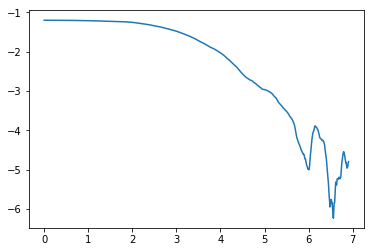

In [146]:
plt.plot(np.log(xrange(1000)), [np.log(np.sum(abs(phi_avg_eig_tot[i] - phi_avg_eig_tot[999]))) for i in xrange(1000)], '-')
plt.show()
#Try Comparing the one-simensional marginal of something with what you'd get if the distribution was just the exponential of the potential

In [143]:
for s in xrange(3):
    plt.subplot(1,3,s+1)
    plt.plot(np.log(xrange(n_iterations)), [np.log(abs(phi_avg_eig_tot[i][s] - phi_avg_un_strat_tot[s])) for i in xrange(n_iterations)], '-')
plt.show()

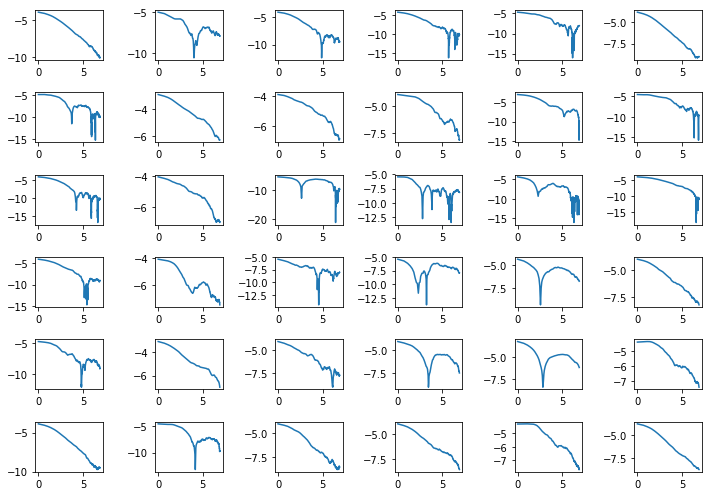

In [110]:
#Compute the un-averaged weights over the run
alpha = 0.5
nu_weights_eig_un_avg = np.zeros((n_iterations, J))
for i in xrange(n_iterations):
    nu_weights_eig_un_avg[i] = np.array(stratified_data[2*i+1][2])
    nu_weights_eig_un_avg[i] = nu_weights_eig_un_avg[i] / (np.sum(nu_weights_eig_un_avg[i]))

#Compute the Averaged Weights over the run
nu_weights_eig_avg = np.zeros((n_iterations, J))
nu_weights_eig_avg_exp = np.zeros((n_iterations, J))
nu_weights_eig_sum = np.zeros(J)
nu_weights_eig_avg_exp[0] = np.array(stratified_data[1][2])
for i in xrange(n_iterations-1):
    nu_weights_eig_sum += np.array(stratified_data[2*i+1][2])
    nu_weights_eig_avg[i] = nu_weights_eig_sum / (i + 1.)
    nu_weights_eig_avg_exp[i+1] = (1. - alpha) * nu_weights_eig_avg_exp[i] + alpha * np.array(stratified_data[2*(i+1)+1][2])
nu_weights_eig_sum += np.array(stratified_data[2*(n_iterations-1)+1][2])
nu_weights_eig_avg[n_iterations-1] = nu_weights_eig_sum / (1. * n_iterations)

plt.figure(figsize = (10,7))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        #plt.figure(figsize = (10,10))
        #plt.ylim()
        #plt.plot(np.log(xrange(n_iterations)), [np.log(abs(nu_weights_eig_un_avg[i][j] - weights_true[j])) for i in xrange(n_iterations)])
        plt.plot(np.log(xrange(n_iterations)), [np.log(abs(weights_sum_eig[i][j]/(i+1.) - weights_true[j])) for i in xrange(n_iterations)])
        #plt.plot(np.log(xrange(n_iterations-1)), [np.log(abs(nu_weights_eig_avg[i+1][j] - nu_weights_eig_avg[i][j])) for i in xrange(n_iterations-1)])

plt.tight_layout()
#plt.show()

In [236]:
np.sqrt(np.var([np.sum(phi_sum_un_strat[0][i+1])-np.sum(phi_sum_un_strat[0][i]) for i in xrange(3199)])/3199.)

0.013850537244522992

In [117]:
min_points = [np.amin(n_exits_in_eig[i]) for i in xrange(n_iterations)]
plt.plot(xrange(n_iterations), min_points, 'o')
print np.amin(np.array(min_points[1:]))

3.0


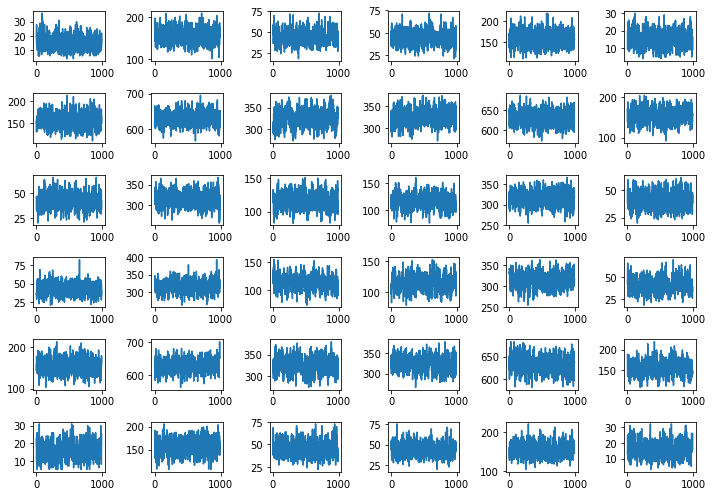

In [131]:
#Plot heat maps in some well converging strata and some"problem" strata
#Plot the number of exits into each stratum over time

n_exits_in_eig = np.zeros((n_iterations, J))
for i in xrange(n_iterations):
    nu_points = stratified_data[2 * i + 1][0]
    for j in xrange(J):
        n_exits_in_eig[i][j] = len(nu_points[j])

plt.figure(figsize = (10,7))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        plt.plot(xrange(n_iterations-10), [n_exits_in_eig[i+10][j] for i in xrange(n_iterations-10)])
plt.tight_layout()
plt.show()

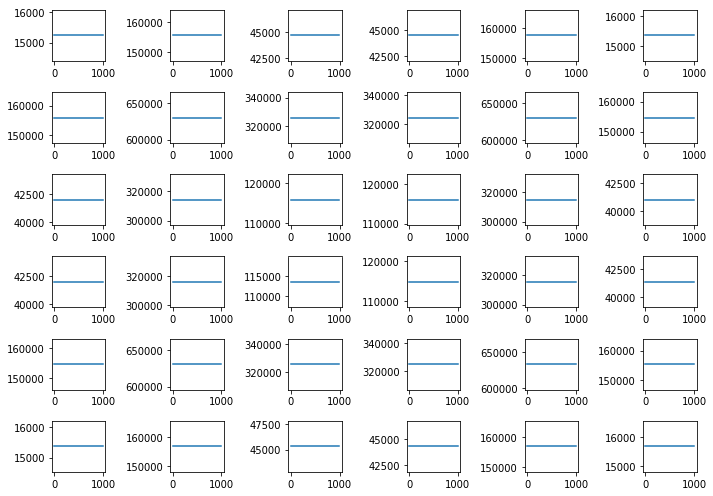

In [178]:
#Compute the variance of the test functions of the un-stratified sample, to see what scale of error it has. Make error bars. 
#Do the same for the stratified iterations. 
#Try making histograms of the test function values. 

plt.figure(figsize = (10,7))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        plt.plot(xrange(n_iterations), [np.sum(n_exits_in_eig[:,j]) for i in xrange(n_iterations)])
        #plt.plot(xrange(n_iterations), [(np.sum(n_exits_in_eig[:,j]) - n_points_un_strat_one_stratum[j])/n_points_un_strat_one_stratum[j] for i in xrange(n_iterations)])
plt.tight_layout()
plt.show()

In [134]:
plt.figure(figsize = (10,7))
for l in xrange(K):
    for k in xrange(K):
        j = l * K + k
    
        plt.subplot(K,K,j+1)
        plt.plot(xrange(n_hist_tot), [n_points_un_strat_one_stratum[j] for i in xrange(n_hist_tot)])
plt.tight_layout()
plt.show()

In [90]:
np.array([1,4])**2

array([ 1, 16])